## Task 1

#### Reading Dataset

In [22]:
import pandas as pd
import numpy as np

In [23]:
transaction_df = pd.read_csv("./ieee-fraud-detection/data_transaction.csv")
identity_df = pd.read_csv("./ieee-fraud-detection/data_identity.csv")

Get the location NaN values for later use.

In [24]:
transaction_notnan_df = transaction_df.notna()
identity_notnan_df = identity_df.notna()

##### Transform categorical data

In [25]:
cat_columns = transaction_df.select_dtypes(['object']).columns
transaction_df[cat_columns] = transaction_df[cat_columns].apply(lambda x: pd.factorize(x, na_sentinel=None)[0]) # can also extract unique values at this stage to apply the same transformation to "future" data

cat_columns = identity_df.select_dtypes(['object']).columns
identity_df[cat_columns] = identity_df[cat_columns].apply(lambda x: pd.factorize(x, na_sentinel=None)[0])

In [26]:
# return NaN values
transaction_df.where(transaction_notnan_df, inplace=True)
identity_df.where(identity_notnan_df, inplace=True)

##### Join the dataframes by TransactionID

In [27]:
data_df = transaction_df.join(identity_df.set_index("TransactionID"), on="TransactionID")
target_df = data_df["isFraud"]

# we don't need `TransactionID` at this point
data_df.drop(["TransactionID", "isFraud", "TransactionDT"], inplace=True, axis=1)

Looking at the description of the features, I decided that TransactionDT can be dropped from the dataset because it is unlikely that a fraud transaction happens at some specific time (timedelta from specific time).

In [28]:
data_notnan_df = data_df.notna()

Now, let's find features where the number of NaN is greater than 90%.

In [29]:
perc = []
uniques = []

for column in data_notnan_df.keys():
    counts = data_notnan_df[column].value_counts(normalize=True)
    if False in counts:
        perc.append(data_notnan_df[column].value_counts(normalize=True)[False])
    else:
        perc.append(0.0)
perc = np.array(perc)

In [30]:
to_drop = []
for id in np.where(perc > 0.9)[0]:
    print(data_notnan_df.keys()[id], "- with the highest frequency of", perc[id] * 100, "%")
    to_drop.append(data_notnan_df.keys()[id])

dist2 - with the highest frequency of 93.62837403054831 %
D7 - with the highest frequency of 93.40992989467267 %
id_07 - with the highest frequency of 99.12707013919464 %
id_08 - with the highest frequency of 99.12707013919464 %
id_18 - with the highest frequency of 92.36072069631184 %
id_21 - with the highest frequency of 99.12639279303687 %
id_22 - with the highest frequency of 99.1246994276425 %
id_23 - with the highest frequency of 99.1246994276425 %
id_24 - with the highest frequency of 99.19615944728554 %
id_25 - with the highest frequency of 99.13096487960172 %
id_26 - with the highest frequency of 99.12571544687913 %
id_27 - with the highest frequency of 99.1246994276425 %


In [31]:
# now drop these columns
data_df.drop(to_drop, inplace=True, axis=1)
data_notnan_df.drop(to_drop, inplace=True, axis=1)

In [32]:
# checking the final number of features
num_features = data_df.shape[1]
data_df.shape[1]

419

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data = scaler.fit_transform(data_df.fillna(0).to_numpy())

data = np.concatenate([data, data_notnan_df.astype("int").to_numpy()], axis=1)
target = target_df.to_numpy()

Split to train and test sets.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

##### Convert to Dataloaders

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
batch = 128

# convert to tensors
X_train_ten = torch.Tensor(X_train)
X_test_ten = torch.Tensor(X_test)
y_train_ten = torch.Tensor(y_train)
y_test_ten = torch.Tensor(y_test)

# create DataLoaders
train_loader = DataLoader(TensorDataset(X_train_ten, y_train_ten), batch_size=batch, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_ten, y_test_ten), batch_size=batch, shuffle=True)

In [16]:
import gc

gc.collect()

40

#### Define Autoencoders

##### Undercomplete Autoencoder

In [17]:
## modified undercomplete AE from the lab
class under_autoencoder(nn.Module):
    def __init__(self, input_size, latent_dim):
      super(under_autoencoder, self).__init__()
      # Step 1 : Define the encoder 
      # Step 2 : Define the decoder
      # Step 3 : Initialize the weights (optional)
      self.encoder = nn.Sequential(
          nn.Linear(input_size, input_size//2),
          nn.ReLU(True),
          nn.Linear(input_size//2, input_size//3),
          nn.Linear(input_size//3, input_size//4),
          nn.Tanh(),
          nn.Linear(input_size//4, latent_dim)
      )
      # the output size of the decoder should be twice smaller than the input size to the encoder
      self.decoder = nn.Sequential(
          nn.Linear(latent_dim, input_size//4),
          nn.ReLU(True),
          nn.Linear(input_size//4, input_size//3),
          nn.Tanh(),
          nn.Linear(input_size//3, input_size//2)
      )
      self.encoder.apply(self.__init_weights)
      self.decoder.apply(self.__init_weights)
        
    def forward(self, x):
      # Step 1: Pass the input through encoder to get latent representation
      # Step 2: Take latent representation and pass through decoder
      x = self.encoder(x)
      x = self.decoder(x)
      return x
        
    
    def encode(self,input):
      #Step 1: Pass the input through the encoder to get latent representation
      return self.encoder(input)
    
    def decode(self, input):
      return self.decoder(input)
    
    def __init_weights(self,m):
      #Init the weights (optional)
      if type(m) == nn.Linear:
          torch.nn.init.xavier_uniform_(m.weight)
          m.bias.data.fill_(0.01)

Train and save the model

In [18]:
learning_rate = 1e-4
eps = 1e-9

AE = under_autoencoder(num_features * 2, 50).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(AE.parameters(), lr=learning_rate, eps=eps)

In [19]:
num_epochs = 20

best_model = AE.state_dict()
best_loss = 1e300
best_epoch = 0

for epoch in range(num_epochs):
  epoch_loss = 0.0
  for X, _ in train_loader:
    X = X.to(device)

    optimizer.zero_grad()
    # forward
    output = AE(X)
    loss = criterion(output * X[:, num_features:], X[:, :num_features] * X[:, num_features:])

    # backward
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  # log
  print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, epoch_loss / len(train_loader)))
  
  # test the model
  with torch.no_grad():
    tot_loss = 0
    for X, _ in test_loader:
      X = X.to(device)
      
      output = AE(X)
      tot_loss += criterion(output * X[:, num_features:], X[:, :num_features] * X[:, num_features:]).item()
      
    tot_loss = tot_loss / len(test_loader)
    
    print("Test loss:", tot_loss)
      
    if tot_loss < best_loss:
      best_loss = tot_loss
      best_model = AE.state_dict()
      best_epoch = epoch
    else:
      AE.load_state_dict(best_model)
      
print(f"The best test loss is {best_loss}, from the epoch number {best_epoch + 1}")

epoch [1/20], loss:0.3624
Test loss: 0.22732325501635042
epoch [2/20], loss:0.2279
Test loss: 0.17208643752036218
epoch [3/20], loss:0.1887
Test loss: 0.14193195246264967
epoch [4/20], loss:0.1663
Test loss: 0.12429866267979661
epoch [5/20], loss:0.1509
Test loss: 0.11046910814674549
epoch [6/20], loss:0.1391
Test loss: 0.1021279075999269
epoch [7/20], loss:0.1298
Test loss: 0.09494855206052118
epoch [8/20], loss:0.1227
Test loss: 0.08900108674131454
epoch [9/20], loss:0.1167
Test loss: 0.08324758570847118
epoch [10/20], loss:0.1116
Test loss: 0.08061794713260616
epoch [11/20], loss:0.1074
Test loss: 0.0796843282051005
epoch [12/20], loss:0.1037
Test loss: 0.07389193859237891
epoch [13/20], loss:0.1004
Test loss: 0.0726265738680878
epoch [14/20], loss:0.0976
Test loss: 0.06828383189844994
epoch [15/20], loss:0.0949
Test loss: 0.06652549975617252
epoch [16/20], loss:0.0925
Test loss: 0.06578540365501254
epoch [17/20], loss:0.0903
Test loss: 0.06184406145874367
epoch [18/20], loss:0.0882

In [20]:
torch.save(best_model, "undercomplete_AE_90")

In [21]:
gc.collect()

40

##### Regularized Autoencoder

For the Regularized Autoencoder I will use the Undercomple Autoencoder and add the regularization loss.

In [38]:
learning_rate = 1e-4
eps = 1e-9

AE = under_autoencoder(num_features * 2, 200).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(AE.parameters(), lr=learning_rate, eps=eps)

In [39]:
num_epochs = 20

best_model = AE.state_dict()
best_loss = 1e300
best_epoch = 0

l1_lambda = 0.0001

for epoch in range(num_epochs):
  epoch_loss = 0.0
  for X, _ in train_loader:
    X = X.to(device)

    optimizer.zero_grad()
    # forward
    output = AE(X)
    loss = criterion(output * X[:, num_features:], X[:, :num_features] * X[:, num_features:])
    
    # l1 regularization
    l1_penalty = 0.
    for param in AE.parameters():
        l1_penalty += torch.abs((torch.norm(param, 1)))
    l1_penalty *= l1_lambda
    
    loss += l1_penalty

    # backward
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  # log
  print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, epoch_loss / len(train_loader)))
  
  # test the model
  with torch.no_grad():
    tot_loss = 0
    for X, _ in test_loader:
      X = X.to(device)
      
      output = AE(X)
      tot_loss += criterion(output * X[:, num_features:], X[:, :num_features] * X[:, num_features:]).item() # test loss doesn't need regularization
      
    tot_loss = tot_loss / len(test_loader)
    
    print("Test loss:", tot_loss)
      
    if tot_loss < best_loss:
      best_loss = tot_loss
      best_model = AE.state_dict()
      best_epoch = epoch
    else:
      AE.load_state_dict(best_model)
      
print(f"The best test loss is {best_loss}, from the epoch number {best_epoch + 1}")

epoch [1/20], loss:1.1609
Test loss: 0.5014686604814437
epoch [2/20], loss:0.7149
Test loss: 0.48561864939567717
epoch [3/20], loss:0.6872
Test loss: 0.4730972411314819
epoch [4/20], loss:0.6731
Test loss: 0.46783718134186764
epoch [5/20], loss:0.6644
Test loss: 0.46378612052548357
epoch [6/20], loss:0.6585
Test loss: 0.4622094596969216
epoch [7/20], loss:0.6540
Test loss: 0.4578273663396179
epoch [8/20], loss:0.6504
Test loss: 0.45555520049606085
epoch [9/20], loss:0.6475
Test loss: 0.4548884904978722
epoch [10/20], loss:0.6452
Test loss: 0.4531111777280805
epoch [11/20], loss:0.6433
Test loss: 0.4489690228118153
epoch [12/20], loss:0.6416
Test loss: 0.44786768808621885
epoch [13/20], loss:0.6402
Test loss: 0.45083763472986116
epoch [14/20], loss:0.6388
Test loss: 0.4476345676125581
epoch [15/20], loss:0.6370
Test loss: 0.4441946236858647
epoch [16/20], loss:0.6354
Test loss: 0.44137224243431156
epoch [17/20], loss:0.6338
Test loss: 0.43847547282635324
epoch [18/20], loss:0.6324
Test 

In [40]:
torch.save(AE.state_dict(), "regularized_AE")

In [41]:
gc.collect()

40

##### Variational Autoencoder

In [42]:
# VAE model from the lab
class var_autoencoder(nn.Module):
    def __init__(self, input_size, z_dim=200):
        super(var_autoencoder, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size//2)
        self.fc2 = nn.Linear(input_size//2, input_size//3)
        self.fc3 = nn.Linear(input_size//3, input_size//4)
        
        self.fc4 = nn.Linear(input_size//4, z_dim)
        self.fc5 = nn.Linear(input_size//4, z_dim)
        
        self.fc6 = nn.Linear(z_dim, input_size//4)
        self.fc7 = nn.Linear(input_size//4, input_size//3)
        self.fc8 = nn.Linear(input_size//3, input_size//2)
        
        # weight init
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc1.bias.data.fill_(0.01)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.fc2.bias.data.fill_(0.01)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        self.fc3.bias.data.fill_(0.01)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
        self.fc4.bias.data.fill_(0.01)
        torch.nn.init.xavier_uniform_(self.fc5.weight)
        self.fc5.bias.data.fill_(0.01)
        torch.nn.init.xavier_uniform_(self.fc6.weight)
        self.fc6.bias.data.fill_(0.01)
        torch.nn.init.xavier_uniform_(self.fc7.weight)
        self.fc7.bias.data.fill_(0.01)
        torch.nn.init.xavier_uniform_(self.fc8.weight)
        self.fc8.bias.data.fill_(0.01)
        
    def encode(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.tanh(self.fc3(x))
        
        return self.fc4(x), self.fc5(x)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = torch.relu(self.fc6(z))
        x = self.fc7(x)
        
        return self.fc8(x)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

Train and save the model

In [43]:
learning_rate = 1e-4
eps = 1e-9

AE = var_autoencoder(num_features * 2, 200).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(AE.parameters(), lr=learning_rate, eps=eps)

In [44]:
num_epochs = 20

best_model = AE.state_dict()
best_loss = 1e300
best_epoch = 0

for epoch in range(num_epochs):
  epoch_loss = 0.0
  for X, _ in train_loader:
    X = X.to(device)

    optimizer.zero_grad()
    # forward
    output, mu, log_var = AE(X)
    loss = criterion(output * X[:, num_features:], X[:, :num_features] * X[:, num_features:])
    
    # KL divergence loss
    kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    loss += kl_div

    # backward
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  # log
  print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
  
  # test the model
  with torch.no_grad():
    tot_loss = 0
    for X, _ in test_loader:
      X = X.to(device)
      
      output, _, _ = AE(X)
      tot_loss += criterion(output * X[:, num_features:], X[:, :num_features] * X[:, num_features:])
      
    tot_loss = (tot_loss / len(test_loader)).item()
    
    print("Test loss:", tot_loss)
      
    if tot_loss < best_loss:
      best_loss = tot_loss
      best_model = AE.state_dict()
      best_epoch = epoch
    else:
      AE.load_state_dict(best_model)
      
print(f"The best test loss is {best_loss}, from the epoch number {best_epoch + 1}")

epoch [1/20], loss:0.9590
Test loss: 0.8017974495887756
epoch [2/20], loss:1.0104
Test loss: 0.7989159226417542
epoch [3/20], loss:0.9252
Test loss: 0.7989183664321899
epoch [4/20], loss:0.8013
Test loss: 0.7988237738609314
epoch [5/20], loss:0.4514
Test loss: 0.7985378503799438
epoch [6/20], loss:0.4425
Test loss: 0.7979228496551514
epoch [7/20], loss:0.4361
Test loss: 0.7978017926216125
epoch [8/20], loss:0.7449
Test loss: 0.7977657914161682
epoch [9/20], loss:0.8682
Test loss: 0.7976951003074646
epoch [10/20], loss:0.7194
Test loss: 0.797690749168396
epoch [11/20], loss:2.0911
Test loss: 0.797721803188324
epoch [12/20], loss:1.5358
Test loss: 0.7976062297821045
epoch [13/20], loss:0.3985
Test loss: 0.7976194620132446
epoch [14/20], loss:0.6100
Test loss: 0.7977754473686218
epoch [15/20], loss:1.0431
Test loss: 0.7974475622177124
epoch [16/20], loss:0.3505
Test loss: 0.7980749011039734
epoch [17/20], loss:0.4617
Test loss: 0.7978585958480835
epoch [18/20], loss:0.9675
Test loss: 0.79

In [45]:
torch.save(best_model, "variational_AE")

In [46]:
gc.collect()

51

#### Compare the performance

In [19]:
criterion = nn.MSELoss()

##### Undercomplete Autoencoder

In [23]:
# load the model
AE = under_autoencoder(num_features * 2, 50).to(device)
AE.load_state_dict(torch.load("undercomplete_AE_90"))
AE.eval()

# test the model
tot_under_loss = 0
under_losses = []

with torch.no_grad():
    
    for X, _ in test_loader:
        X = X.to(device)
        
        output = AE(X)
        
        loss = criterion(output * X[:, num_features:], X[:, :num_features] * X[:, num_features:]).item()
        tot_under_loss += loss
        under_losses.append(loss)
        
    tot_under_loss = tot_under_loss / len(test_loader)

print("Test loss for the Undercomplete AE:", tot_under_loss)

Test loss for the Undercomplete AE: 0.057757683858105896


##### Regularized Autoencoder

In [49]:
# load the model
AE = under_autoencoder(num_features * 2, 200).to(device)
AE.load_state_dict(torch.load("regularized_AE"))
AE.eval()

# test the model
tot_reg_loss = 0
reg_losses = []

with torch.no_grad():
    
    for X, _ in test_loader:
        X = X.to(device)
        
        output = AE(X)
        
        loss = criterion(output * X[:, num_features:], X[:, :num_features] * X[:, num_features:]).item()
        tot_reg_loss += loss
        reg_losses.append(loss)
        
    tot_reg_loss = tot_reg_loss / len(test_loader)

print("Test loss for the Regularized AE:", tot_reg_loss)

Test loss for the Regularized AE: 0.4389021351917335


##### Variational Autoencoder

In [50]:
# load the model
AE = var_autoencoder(num_features * 2, 200).to(device)
AE.load_state_dict(torch.load("variational_AE"))
AE.eval()

# test the model
tot_var_loss = 0
var_losses = []

with torch.no_grad():
    tot_loss = 0
    for X, _ in test_loader:
        X = X.to(device)
        
        output, _, _ = AE(X)
        
        loss = criterion(output * X[:, num_features:], X[:, :num_features] * X[:, num_features:]).item()
        tot_var_loss += loss
        var_losses.append(loss)
        
    tot_var_loss = tot_var_loss / len(test_loader)
    
print("Test loss for the Variational AE:", tot_var_loss)

Test loss for the Variational AE: 0.7974968499151883


In [51]:
gc.collect()

20

##### Plot the performance

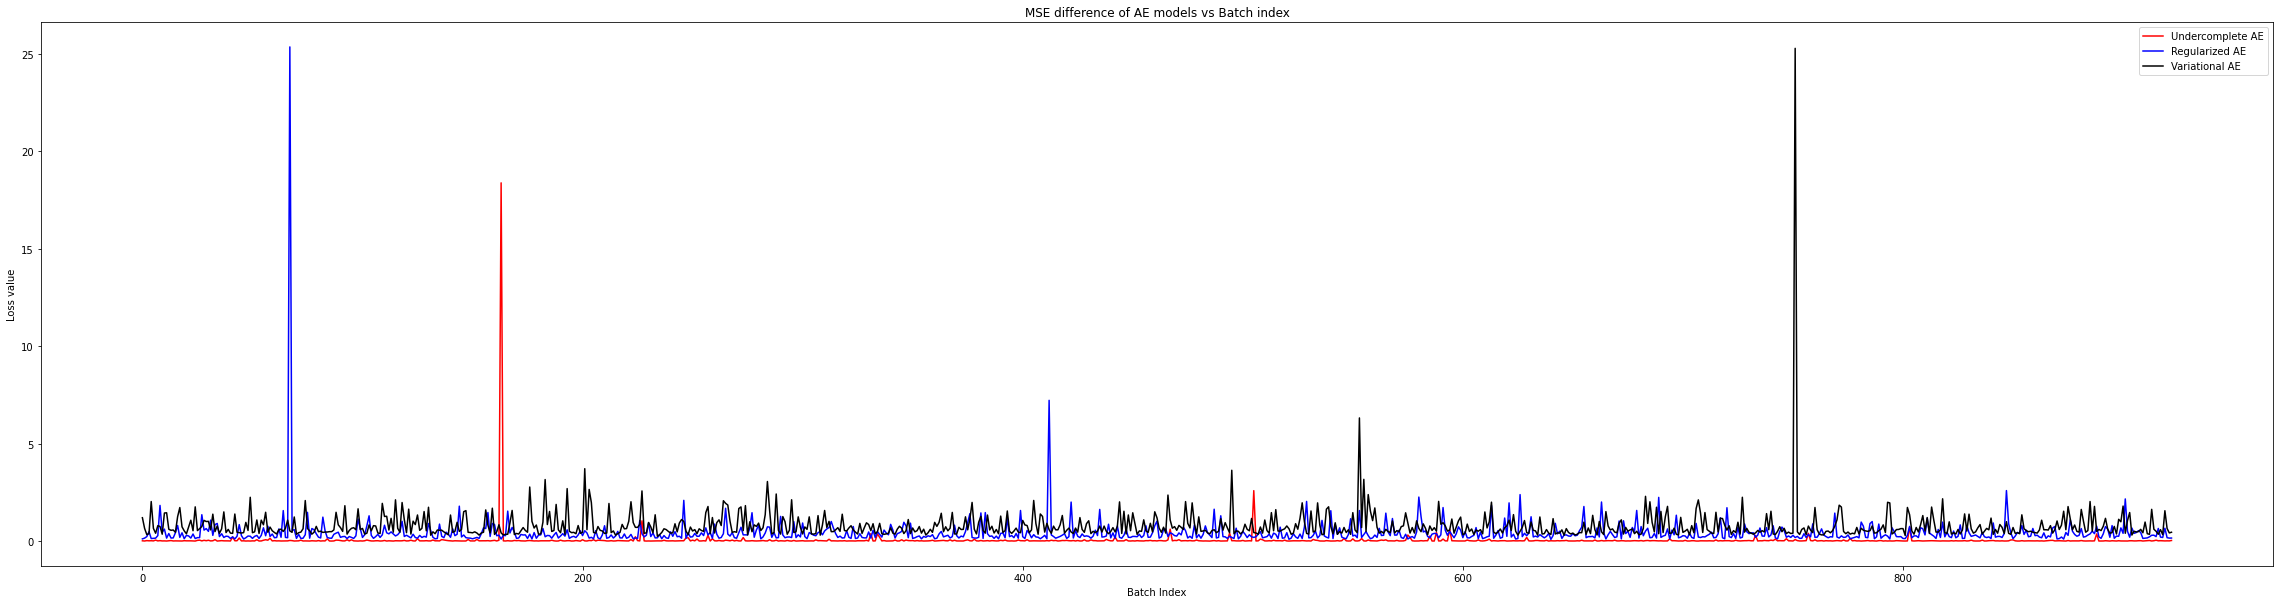

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 10))
l1 = plt.plot(range(len(under_losses)), under_losses, c="red")
l2 = plt.plot(range(len(reg_losses)), reg_losses, c="blue")
l3 = plt.plot(range(len(var_losses)), var_losses, c="black")
plt.title("MSE difference of AE models vs Batch index")
plt.xlabel("Batch Index")
plt.ylabel("Loss value")
plt.legend([l1[0], l2[0], l3[0]], ["Undercomplete AE", "Regularized AE", "Variational AE"])

These spikes make it difficult to read the graph, so I will remove them.

In [53]:
under_losses = np.array(under_losses)
reg_losses = np.array(reg_losses)
var_losses = np.array(var_losses)

under_losses = under_losses[np.where(under_losses < 4)]
reg_losses = reg_losses[np.where(reg_losses < 4)]
var_losses = var_losses[np.where(var_losses < 4)]

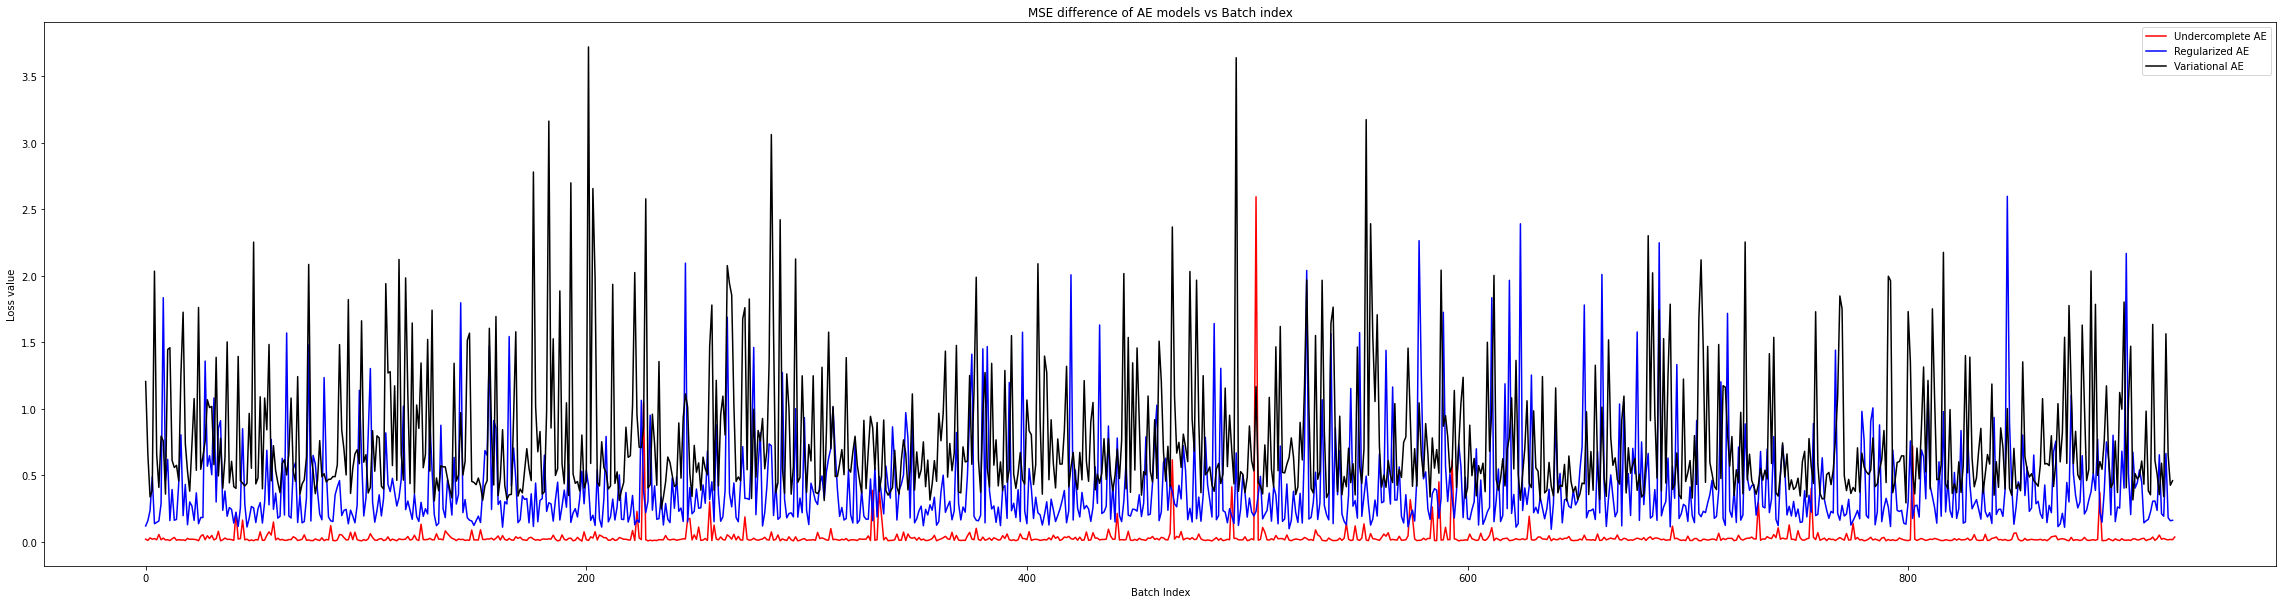

In [54]:
plt.figure(figsize=(40, 10))
l1 = plt.plot(range(len(under_losses)), under_losses, c="red")
l2 = plt.plot(range(len(reg_losses)), reg_losses, c="blue")
l3 = plt.plot(range(len(var_losses)), var_losses, c="black")
plt.title("MSE difference of AE models vs Batch index")
plt.xlabel("Batch Index")
plt.ylabel("Loss value")
plt.legend([l1[0], l2[0], l3[0]], ["Undercomplete AE", "Regularized AE", "Variational AE"])

According to the graph above and to the total value of loss across the whole test dataset, the best performing autoencoder is `the Undercomplete Autoencoder`, with the total value of the Mean Squared Error of `0.1257`.

##### Compare to the Statistical Methods

In order to compare the performance of the autoencoder versus statistical approaches, I will classify the dataset using Random Forest Classifier from sklearn.

Let's look at the performance of `undercomplete_AE_70`.

In [18]:
# load the model
AE = under_autoencoder(num_features * 2, 50).to(device)
AE.load_state_dict(torch.load("undercomplete_AE_70"))
AE.eval()

# regenerate the dataset
train_outputs = []
train_targets = []

for X, target in train_loader:
    X = X.to(device)
    train_outputs.append(AE(X).cpu().detach().numpy())
    train_targets.append(target.cpu().detach().numpy())
    
train_outputs = np.concatenate(train_outputs, axis=0)
train_targets = np.concatenate(train_targets, axis=0)

test_outputs = []
test_targets = []

for X, target in test_loader:
    X = X.to(device)
    test_outputs.append(AE(X).cpu().detach().numpy())
    test_targets.append(target.cpu().detach().numpy())
    
test_outputs = np.concatenate(test_outputs, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

In [25]:
from sklearn.ensemble import RandomForestClassifier

# clasify
classifier = RandomForestClassifier(max_depth=200, n_jobs=-1)

classifier.fit(train_outputs, train_targets)
pred_targets = classifier.predict(test_outputs)

In [26]:
from sklearn.metrics import classification_report

print(classification_report(test_targets, pred_targets))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    113955
         1.0       0.87      0.30      0.45      4153

    accuracy                           0.97    118108
   macro avg       0.92      0.65      0.72    118108
weighted avg       0.97      0.97      0.97    118108



In [27]:
gc.collect()

88

F1 score is `0.45` for minority class. I will use `ADSYN` oversampling method to fix it.

In [19]:
from imblearn.over_sampling import ADASYN

ada = ADASYN(n_jobs=-1)
train_outputs_res, train_targets_res = ada.fit_resample(train_outputs, train_targets)

In [20]:
from sklearn.ensemble import RandomForestClassifier

# clasify
classifier = RandomForestClassifier(max_depth=200, n_jobs=-1)

classifier.fit(train_outputs_res, train_targets_res)
pred_targets = classifier.predict(test_outputs)

In [21]:
from sklearn.metrics import classification_report

print(classification_report(test_targets, pred_targets))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    114064
         1.0       0.54      0.52      0.53      4044

    accuracy                           0.97    118108
   macro avg       0.76      0.75      0.76    118108
weighted avg       0.97      0.97      0.97    118108



In [22]:
gc.collect()

208

Now, let's compare it to `undercomplete_AE_90`.

In [18]:
# load the model
AE = under_autoencoder(num_features * 2, 50).to(device)
AE.load_state_dict(torch.load("undercomplete_AE_90"))
AE.eval()

# regenerate the dataset
train_outputs = []
train_targets = []

for X, target in train_loader:
    X = X.to(device)
    train_outputs.append(AE(X).cpu().detach().numpy())
    train_targets.append(target.cpu().detach().numpy())
    
train_outputs = np.concatenate(train_outputs, axis=0)
train_targets = np.concatenate(train_targets, axis=0)

test_outputs = []
test_targets = []

for X, target in test_loader:
    X = X.to(device)
    test_outputs.append(AE(X).cpu().detach().numpy())
    test_targets.append(target.cpu().detach().numpy())
    
test_outputs = np.concatenate(test_outputs, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

In [25]:
from sklearn.ensemble import RandomForestClassifier

# clasify
classifier = RandomForestClassifier(max_depth=200, n_jobs=-1)

classifier.fit(train_outputs, train_targets)
pred_targets = classifier.predict(test_outputs)

In [26]:
from sklearn.metrics import classification_report

print(classification_report(test_targets, pred_targets))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    114029
         1.0       0.91      0.36      0.51      4079

    accuracy                           0.98    118108
   macro avg       0.94      0.68      0.75    118108
weighted avg       0.98      0.98      0.97    118108



In [19]:
gc.collect()

20

Now, let's see if we can improve the results.

In [25]:
from imblearn.over_sampling import ADASYN

ada = ADASYN(n_jobs=-1)
train_outputs_res, train_targets_res = ada.fit_resample(train_outputs, train_targets)

In [26]:
from sklearn.ensemble import RandomForestClassifier

# clasify
classifier = RandomForestClassifier(max_depth=200, n_jobs=-1)

classifier.fit(train_outputs_res, train_targets_res)
pred_targets = classifier.predict(test_outputs)

In [27]:
from sklearn.metrics import classification_report

print(classification_report(test_targets, pred_targets))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99    113953
         1.0       0.66      0.53      0.59      4155

    accuracy                           0.97    118108
   macro avg       0.82      0.76      0.79    118108
weighted avg       0.97      0.97      0.97    118108



In [28]:
gc.collect()

304

In [21]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(n_jobs=-1)
train_outputs_res, train_targets_res = sm.fit_resample(train_outputs, train_targets)

In [22]:
from sklearn.ensemble import RandomForestClassifier

# clasify
classifier = RandomForestClassifier(max_depth=200, n_jobs=-1)

classifier.fit(train_outputs_res, train_targets_res)
pred_targets = classifier.predict(test_outputs)

In [23]:
from sklearn.metrics import classification_report

print(classification_report(test_targets, pred_targets))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99    113953
         1.0       0.68      0.54      0.60      4155

    accuracy                           0.97    118108
   macro avg       0.83      0.77      0.79    118108
weighted avg       0.97      0.97      0.97    118108



In [24]:
gc.collect()

88

`SMOTE` over-sampling performs better.

And the performance of the statistical method.

I will replace all nan values with mean value of the respective category.

In [23]:
# this link helped me understand how to replace values in numpy.ndarray using masked arrays -> https://stackoverflow.com/questions/18689235/numpy-array-replace-nan-values-with-average-of-columns

train_outputs = []
train_targets = []
train_masks = []

for X, target in train_loader:
    X = X.cpu().detach().numpy()
    
    train_outputs.append(X[:, :num_features])
    train_masks.append(X[:, num_features:])
    train_targets.append(target.cpu().detach().numpy())

train_outputs = np.concatenate(train_outputs, axis=0)
train_masks = np.concatenate(train_masks, axis=0) # 1 means a non-nan value; 0 means a nan value
train_targets = np.concatenate(train_targets, axis=0)

train_outputs = np.where(train_masks < 1, np.ma.array(train_outputs, mask=(train_masks < 1)).mean(axis=0), train_outputs)
    
test_outputs = []
test_targets = []
test_masks = []

for X, target in test_loader:
    X = X.cpu().detach().numpy()
    
    test_outputs.append(X[:, :num_features])
    test_masks.append(X[:, num_features:])
    test_targets.append(target.cpu().detach().numpy())

test_outputs = np.concatenate(test_outputs, axis=0)
test_masks = np.concatenate(test_masks, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

test_outputs = np.where(test_masks < 1, np.ma.array(test_outputs, mask=(test_masks < 1)).mean(axis=0), test_outputs)

In [24]:
# clasify
classifier = RandomForestClassifier(max_depth=200, n_jobs=-1)

classifier.fit(train_outputs, train_targets)
pred_targets = classifier.predict(test_outputs)

In [25]:
print(classification_report(test_targets, pred_targets))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    113984
         1.0       0.94      0.42      0.58      4124

    accuracy                           0.98    118108
   macro avg       0.96      0.71      0.79    118108
weighted avg       0.98      0.98      0.97    118108



In [26]:
gc.collect()

88

The F1 score of undercomplete autoencoder shows better results than statistical method by `0.2`, which is almost insignificant improvement.

##### Dimension Reduction

The only way to reduce dimensions in the Task 1 is to reduce dimensions after the empty values have been filled. Otherwise it doesn't make sense.

Let's see the effect of the dimension reduction on the accuracy of the RandomForest Classifier.

For this part, I will use the Undercomplete Autoencoder because it showed the best performance among other autoencoders.

In [18]:
# load the model
AE = under_autoencoder(num_features * 2, 50).to(device)
AE.load_state_dict(torch.load("undercomplete_AE_90"))
AE.eval()

# regenerate the dataset
train_outputs = []
train_targets = []

for X, target in train_loader:
    X = X.to(device)
    train_outputs.append(AE(X).cpu().detach().numpy())
    train_targets.append(target.cpu().detach().numpy())
    
train_outputs = np.concatenate(train_outputs, axis=0)
train_targets = np.concatenate(train_targets, axis=0)

test_outputs = []
test_targets = []

for X, target in test_loader:
    X = X.to(device)
    test_outputs.append(AE(X).cpu().detach().numpy())
    test_targets.append(target.cpu().detach().numpy())
    
test_outputs = np.concatenate(test_outputs, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

In [19]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(n_jobs=-1)
train_outputs_res, train_targets_res = sm.fit_resample(train_outputs, train_targets)

In [20]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

First, let's determine the most optimal number of components.

In [30]:
pca = PCA(100)
pca.fit(train_outputs)

PCA(n_components=100)

Text(0, 0.5, 'Explained ratio')

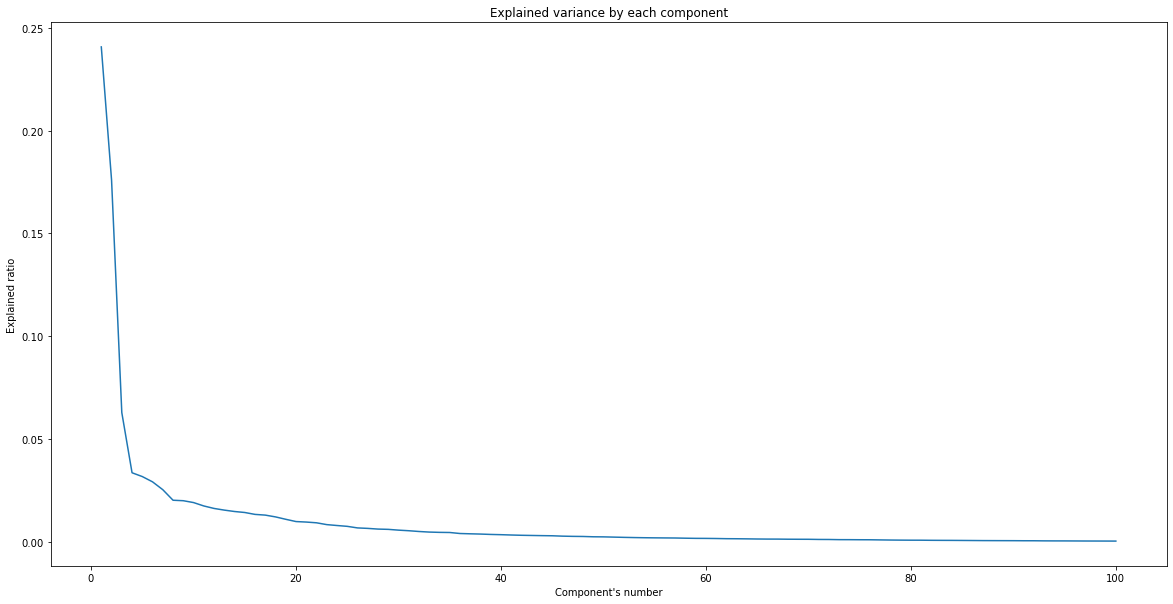

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(range(1, 101), pca.explained_variance_ratio_)
plt.title("Explained variance by each component")
plt.xlabel("Component's number")
plt.ylabel("Explained ratio")

Text(0, 0.5, 'Explained ratio')

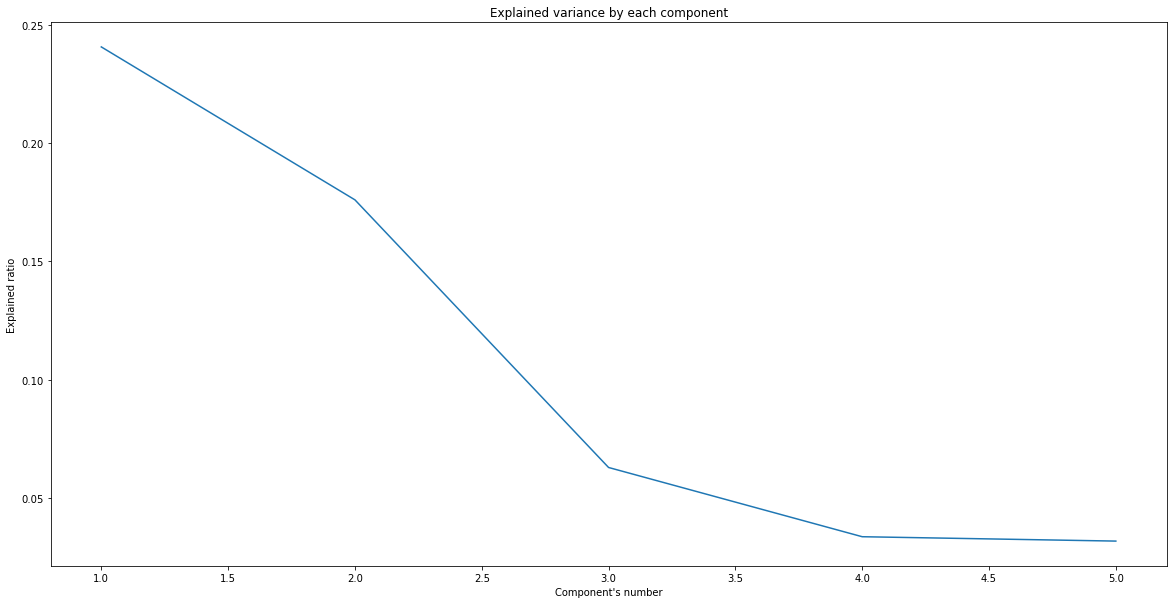

In [33]:
plt.figure(figsize=(20, 10))
plt.plot(range(1, 6), pca.explained_variance_ratio_[:5])
plt.title("Explained variance by each component")
plt.xlabel("Component's number")
plt.ylabel("Explained ratio")

In [34]:
pca.explained_variance_ratio_[:2].sum()

0.41677387702916335

Looks like `42%` of the variance is explained by only 2 components, while others do not contribute as much.

And let's explore it for resampled data.

In [35]:
# 100 components explain nearly the whole variance, thus, I will use it
pca = PCA(100)
pca.fit(train_outputs_res)
pca.explained_variance_ratio_.sum()

0.9948761002903136

Text(0, 0.5, 'Explained ratio')

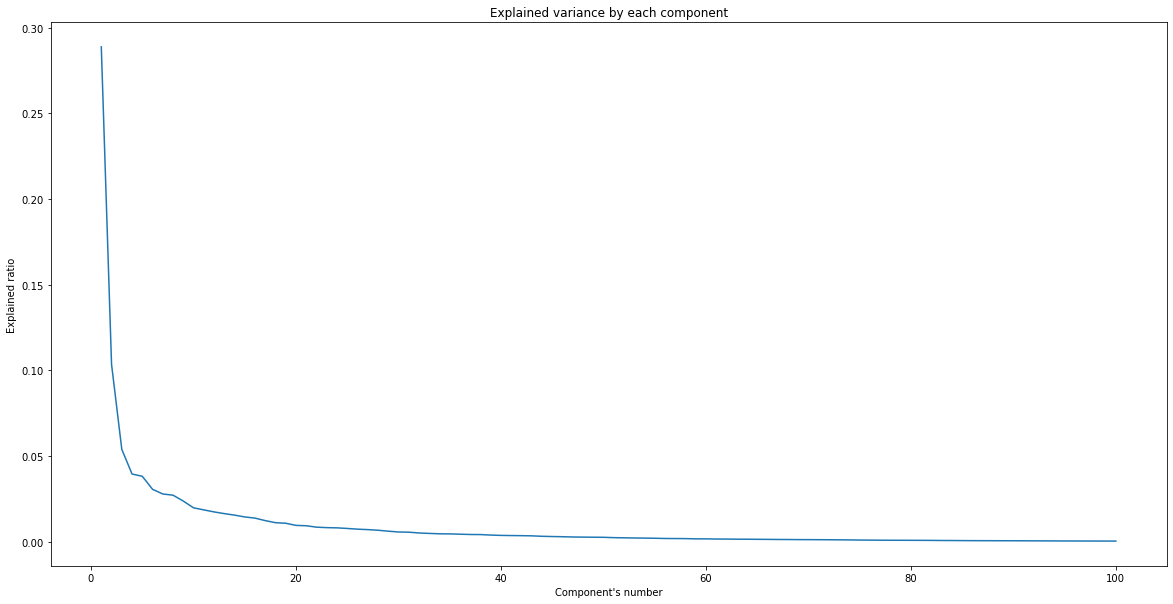

In [36]:
plt.figure(figsize=(20, 10))
plt.plot(range(1, 101), pca.explained_variance_ratio_)
plt.title("Explained variance by each component")
plt.xlabel("Component's number")
plt.ylabel("Explained ratio")

Text(0, 0.5, 'Explained ratio')

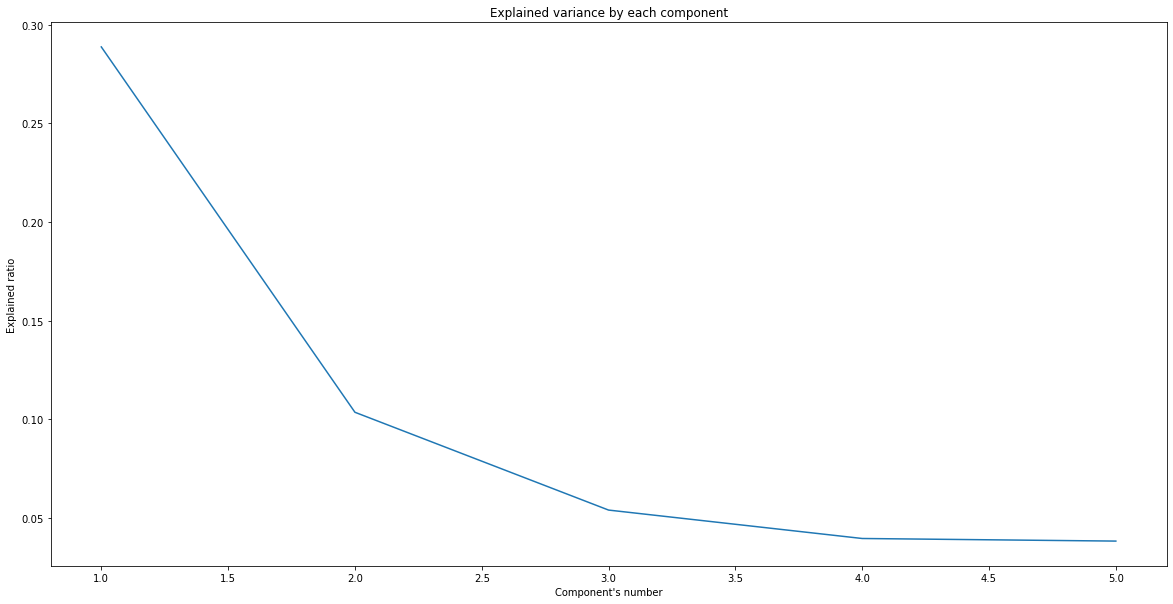

In [37]:
plt.figure(figsize=(20, 10))
plt.plot(range(1, 6), pca.explained_variance_ratio_[:5])
plt.title("Explained variance by each component")
plt.xlabel("Component's number")
plt.ylabel("Explained ratio")

In [39]:
pca.explained_variance_ratio_[:3].sum()

0.44625594799573876

This time PCA needs 3 componets to achive nearly `45%`.

In [ ]:
reduced_train_outputs = pca.transform(train_outputs_res)
reduced_test_outputs = pca.transform(test_outputs)

In [41]:
# clasify
classifier = RandomForestClassifier(max_depth=200, n_jobs=-1)

classifier.fit(reduced_train_outputs, train_targets_res)
pred_targets = classifier.predict(reduced_test_outputs)

In [42]:
print(classification_report(test_targets, pred_targets))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99    113984
         1.0       0.61      0.50      0.55      4124

    accuracy                           0.97    118108
   macro avg       0.80      0.75      0.77    118108
weighted avg       0.97      0.97      0.97    118108



In [22]:
gc.collect()

40

PCA with 100 components (and lower) made it worse.

Let's look at LDA.

In [23]:
lda = LinearDiscriminantAnalysis()
lda.fit(train_outputs_res, train_targets_res)

LinearDiscriminantAnalysis()

In [25]:
from sklearn.metrics import classification_report

pred_targets = lda.predict(test_outputs)
print(classification_report(test_targets, pred_targets))

              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89    113941
         1.0       0.12      0.72      0.21      4167

    accuracy                           0.81    118108
   macro avg       0.55      0.76      0.55    118108
weighted avg       0.96      0.81      0.87    118108



LDA seems to also perform worse.

In conclusion, the autoencoder approach failed to outperform the statistical method. My assumption is that this was due to the significant imblace between the classes. Probably the autoencoder approach would perform better with a more fai dataset because it will be able to learn the pattern of the fraud transactions, as well as the pattern of legit transactions.

## Task 2

#### Reading the data

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 50)

In [2]:
test_df = pd.read_csv("./task2_set/UNSW_NB15_training-set.csv")
train_df = pd.read_csv("./task2_set/UNSW_NB15_testing-set.csv")
# for some reason the names of the files are switched

There is no 'NaN' values according to the pandas. Closer inspection shows that there is no empty fields, but there NaN like values for some of the features.

#### Data Preprocessing

There are only 4 categorical features.

In [3]:
# need to preserve the same transformation among the different dfs
train_df_len = len(train_df)
data_df = pd.concat([train_df, test_df])

cat_columns = data_df.select_dtypes(['object']).columns
data_df[cat_columns] = data_df[cat_columns].apply(lambda x: pd.factorize(x, na_sentinel=None)[0])

# split the arrays back
train_df = data_df.iloc[:train_df_len].copy()
test_df = data_df.iloc[train_df_len:].copy()

Now, lets find column which have mostly the single value in them. I will look only through the `train_df` because it will be used to train the model.

In [4]:
perc = []
uniques = []

for column in train_df.keys():
    perc.append(train_df[column].value_counts(normalize=True).reset_index()[column][0])
    uniques.append(len(train_df[column].unique()) / len(train_df[column]))
perc = np.array(perc)
uniques = np.array(uniques)

In [5]:
for id in np.where(perc > 0.97)[0]:
    print(train_df.keys()[id], "- with the highest frequency of", perc[id] * 100, "%")

is_ftp_login - with the highest frequency of 98.535995574338 %
ct_ftp_cmd - with the highest frequency of 98.535995574338 %
is_sm_ips_ports - with the highest frequency of 98.4247837071763 %


In [6]:
for id in np.where(uniques > 0.9)[0]:
    print(train_df.keys()[id], "- with the highest uniques", uniques[id] * 100, "% of the total")

id - with the highest uniques 100.0 % of the total


Columns `is_ftp_login`, `ct_ftp_cmd`, and `is_sm_ips_ports` have more than 98% of their values equal to specific value, meaning that they contain almost no information. `id` is unique for each entry and contains no information. `label` is used to indicate whether or not a given datapoint is an intrusion and it is irrelevant for this task. `attack_cat` is the target value.

Thus, the above mentioned columns will be dropped.

In [7]:
to_drop = ["id", "is_ftp_login", "ct_ftp_cmd", "is_sm_ips_ports", "label"]

train_df.drop(to_drop, inplace=True, axis=1)
test_df.drop(to_drop, inplace=True, axis=1)

In [8]:
train_target_df = train_df["attack_cat"]
test_target_df = test_df["attack_cat"]

train_df.drop("attack_cat", inplace=True, axis=1)
test_df.drop("attack_cat", inplace=True, axis=1)

In [9]:
import gc

gc.collect()

100

#### Dataset Creation

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
from sklearn.preprocessing import StandardScaler

batch = 64

scaler = StandardScaler()

# convert to tensors
X_train = torch.Tensor(scaler.fit_transform(train_df.to_numpy()))
X_test = torch.Tensor(scaler.transform(test_df.to_numpy()))
y_train = torch.tensor(train_target_df.to_numpy(dtype=int), dtype=torch.int64)
y_test = torch.tensor(test_target_df.to_numpy(dtype=int), dtype=torch.int64)

# create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch, shuffle=True)

#### Model Definition

In [39]:
class Generator(nn.Module):
    
  def __init__(self, z_size=100, h_dim=128):
    super(Generator, self).__init__()
    
    self.generator = nn.Sequential(
      nn.Linear(z_size, h_dim),
      nn.Linear(h_dim, h_dim*2),
      nn.ReLU(True),
      nn.Linear(h_dim*2, h_dim*4),
      nn.ReLU(True),
      nn.Linear(h_dim*4, 39)
    )
    
    self.generator.apply(self.__init_weights)

  def forward(self, z, y):
    y = F.one_hot(y, num_classes=10)
    
    z = torch.cat((z, y), 1)
    x = self.generator(z)
    
    return x
  
  def __init_weights(self,m):
    #Init the weights (optional)
    if type(m) == nn.Linear:
      torch.nn.init.xavier_uniform_(m.weight)
      m.bias.data.fill_(0.01)
      
    
class Discriminator(nn.Module):

  def __init__(self, h_dim=128):
    super(Discriminator, self).__init__()
    
    self.discriminator = nn.Sequential(
      nn.Linear(49, h_dim*4),
      nn.Linear(h_dim*4, h_dim*2),
      nn.LeakyReLU(inplace=True),
      nn.Linear(h_dim*2, h_dim),
      nn.LeakyReLU(inplace=True),
      nn.Linear(h_dim, 1),
      nn.Sigmoid()
    )
    
    self.discriminator.apply(self.__init_weights)

  def forward(self, x, y):
    y = F.one_hot(y, num_classes=10)
    
    x = torch.cat((x, y), 1)
    x = self.discriminator(x)
    
    return x
  
  def __init_weights(self,m):
    #Init the weights (optional)
    if type(m) == nn.Linear:
      torch.nn.init.xavier_uniform_(m.weight)
      m.bias.data.fill_(0.01)

#### Model training

In [40]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    batch_size = D_out.size(0)
    labels = torch.FloatTensor(batch_size).uniform_(0.9, 1).to(device)
    
    loss_fn = nn.BCELoss()
    
    loss = loss_fn(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    labels = torch.FloatTensor(batch_size).uniform_(0, 0.1).to(device)
    
    loss_fn = nn.BCELoss()
    
    loss = loss_fn(D_out.squeeze(), labels)
    return loss

In [41]:
learning_rate = 1e-4
eps = 1e-9

G = Generator().to(device)
D = Discriminator().to(device)

g_optimizer = torch.optim.RMSprop(G.parameters(), lr=learning_rate, eps=eps)
d_optimizer = torch.optim.RMSprop(D.parameters(), lr=learning_rate, eps=eps)

In [42]:
gc.collect()

253

In [43]:
from tqdm import tqdm

num_epochs = 500
z_size = 90

losses = []

# epoch training loop
for epoch in tqdm(range(num_epochs)):

    # batch training loop
    for batch_i, (X, y) in enumerate(train_loader):
        # create noise
        batch_size = X.size(0)
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float().to(device)
        
        # 1. Train the discriminator on real and fake images
        d_optimizer.zero_grad()
        
        X = X.to(device)
        y = y.to(device)
        
        d_real = D(X, y)
        d_loss = real_loss(d_real)
        
        g_fake = G(z, y)
        
        d_fake = D(g_fake, y)
        d_loss = d_loss + fake_loss(d_fake)
        
        d_loss.backward()
        d_optimizer.step()

        # 2. Train the generator with an adversarial loss
        g_optimizer.zero_grad()
        
        g_fake = G(z, y)
        
        g_loss = real_loss(D(g_fake, y))
        
        g_loss.backward()
        g_optimizer.step()
            
    print('epoch [{}/{}], d_loss: {:6.4f} | g_loss: {:6.4f}'.format(epoch + 1, num_epochs, d_loss.item(), g_loss.item()))
    losses.append((d_loss.item(), g_loss.item()))
    
    if epoch % 10 == 0:
        torch.save(G.state_dict(), f"./GAN/Generator_{epoch}")
        torch.save(D.state_dict(), f"./GAN/Discriminator_{epoch}")

  0%|          | 1/500 [00:23<3:18:11, 23.83s/it]

epoch [1/500], d_loss: 0.8203 | g_loss: 1.8386


  0%|          | 2/500 [00:47<3:18:24, 23.90s/it]

epoch [2/500], d_loss: 0.8177 | g_loss: 1.7143


  1%|          | 3/500 [01:11<3:17:40, 23.86s/it]

epoch [3/500], d_loss: 0.7323 | g_loss: 2.1674


  1%|          | 4/500 [01:35<3:18:18, 23.99s/it]

epoch [4/500], d_loss: 0.9315 | g_loss: 1.6795


  1%|          | 5/500 [01:53<3:00:43, 21.91s/it]

epoch [5/500], d_loss: 0.7773 | g_loss: 1.7086


  1%|          | 6/500 [02:12<2:53:32, 21.08s/it]

epoch [6/500], d_loss: 0.8011 | g_loss: 1.6570


  1%|▏         | 7/500 [02:32<2:51:54, 20.92s/it]

epoch [7/500], d_loss: 0.9004 | g_loss: 1.8706


  2%|▏         | 8/500 [02:49<2:41:47, 19.73s/it]

epoch [8/500], d_loss: 0.9584 | g_loss: 1.5705


  2%|▏         | 9/500 [03:06<2:34:22, 18.87s/it]

epoch [9/500], d_loss: 1.0133 | g_loss: 1.8142


  2%|▏         | 10/500 [03:23<2:29:37, 18.32s/it]

epoch [10/500], d_loss: 0.8890 | g_loss: 1.5762


  2%|▏         | 11/500 [03:40<2:26:00, 17.92s/it]

epoch [11/500], d_loss: 0.9102 | g_loss: 1.7003


  2%|▏         | 12/500 [03:57<2:23:47, 17.68s/it]

epoch [12/500], d_loss: 0.9607 | g_loss: 1.5580


  3%|▎         | 13/500 [04:14<2:22:02, 17.50s/it]

epoch [13/500], d_loss: 0.8898 | g_loss: 1.6624


  3%|▎         | 14/500 [04:31<2:20:54, 17.40s/it]

epoch [14/500], d_loss: 0.9811 | g_loss: 1.6011


  3%|▎         | 15/500 [04:49<2:20:06, 17.33s/it]

epoch [15/500], d_loss: 0.9312 | g_loss: 1.4966


  3%|▎         | 16/500 [05:06<2:19:29, 17.29s/it]

epoch [16/500], d_loss: 0.8095 | g_loss: 1.6733


  3%|▎         | 17/500 [05:23<2:18:45, 17.24s/it]

epoch [17/500], d_loss: 0.8434 | g_loss: 1.5565


  4%|▎         | 18/500 [05:40<2:18:12, 17.20s/it]

epoch [18/500], d_loss: 0.7793 | g_loss: 1.6133


  4%|▍         | 19/500 [05:57<2:17:53, 17.20s/it]

epoch [19/500], d_loss: 1.3600 | g_loss: 1.3661


  4%|▍         | 20/500 [06:14<2:17:42, 17.21s/it]

epoch [20/500], d_loss: 1.0016 | g_loss: 1.3629


  4%|▍         | 21/500 [06:32<2:17:06, 17.18s/it]

epoch [21/500], d_loss: 0.8588 | g_loss: 1.5936


  4%|▍         | 22/500 [06:49<2:16:55, 17.19s/it]

epoch [22/500], d_loss: 0.8849 | g_loss: 1.6135


  5%|▍         | 23/500 [07:06<2:16:50, 17.21s/it]

epoch [23/500], d_loss: 0.8082 | g_loss: 1.7118


  5%|▍         | 24/500 [07:23<2:16:38, 17.22s/it]

epoch [24/500], d_loss: 1.0341 | g_loss: 1.4230


  5%|▌         | 25/500 [07:40<2:16:22, 17.23s/it]

epoch [25/500], d_loss: 0.8476 | g_loss: 1.7541


  5%|▌         | 26/500 [07:58<2:16:12, 17.24s/it]

epoch [26/500], d_loss: 1.2805 | g_loss: 1.8108


  5%|▌         | 27/500 [08:15<2:15:35, 17.20s/it]

epoch [27/500], d_loss: 1.1797 | g_loss: 1.2057


  6%|▌         | 28/500 [08:32<2:15:28, 17.22s/it]

epoch [28/500], d_loss: 0.9655 | g_loss: 1.3566


  6%|▌         | 29/500 [08:49<2:15:06, 17.21s/it]

epoch [29/500], d_loss: 0.8823 | g_loss: 1.4515


  6%|▌         | 30/500 [09:07<2:14:48, 17.21s/it]

epoch [30/500], d_loss: 0.8676 | g_loss: 1.4505


  6%|▌         | 31/500 [09:24<2:14:36, 17.22s/it]

epoch [31/500], d_loss: 0.9290 | g_loss: 1.7030


  6%|▋         | 32/500 [09:41<2:14:18, 17.22s/it]

epoch [32/500], d_loss: 0.8360 | g_loss: 1.5609


  7%|▋         | 33/500 [09:58<2:13:56, 17.21s/it]

epoch [33/500], d_loss: 0.9035 | g_loss: 1.4136


  7%|▋         | 34/500 [10:16<2:13:56, 17.25s/it]

epoch [34/500], d_loss: 1.0382 | g_loss: 1.5103


  7%|▋         | 35/500 [10:33<2:13:43, 17.26s/it]

epoch [35/500], d_loss: 0.9895 | g_loss: 1.3407


  7%|▋         | 36/500 [10:50<2:13:38, 17.28s/it]

epoch [36/500], d_loss: 1.1964 | g_loss: 1.3043


  7%|▋         | 37/500 [11:07<2:12:53, 17.22s/it]

epoch [37/500], d_loss: 0.9972 | g_loss: 1.4063


  8%|▊         | 38/500 [11:24<2:12:18, 17.18s/it]

epoch [38/500], d_loss: 1.0054 | g_loss: 1.4345


  8%|▊         | 39/500 [11:42<2:12:14, 17.21s/it]

epoch [39/500], d_loss: 0.9466 | g_loss: 1.4426


  8%|▊         | 40/500 [11:59<2:12:14, 17.25s/it]

epoch [40/500], d_loss: 1.0723 | g_loss: 1.3168


  8%|▊         | 41/500 [12:16<2:12:06, 17.27s/it]

epoch [41/500], d_loss: 0.9592 | g_loss: 1.4387


  8%|▊         | 42/500 [12:33<2:11:46, 17.26s/it]

epoch [42/500], d_loss: 1.0287 | g_loss: 1.2928


  9%|▊         | 43/500 [12:51<2:11:19, 17.24s/it]

epoch [43/500], d_loss: 0.9982 | g_loss: 1.3307


  9%|▉         | 44/500 [13:08<2:11:55, 17.36s/it]

epoch [44/500], d_loss: 1.1561 | g_loss: 1.5105


  9%|▉         | 45/500 [13:25<2:10:52, 17.26s/it]

epoch [45/500], d_loss: 1.0422 | g_loss: 1.3001


  9%|▉         | 46/500 [13:43<2:10:24, 17.24s/it]

epoch [46/500], d_loss: 1.0190 | g_loss: 1.3334


  9%|▉         | 47/500 [14:00<2:10:14, 17.25s/it]

epoch [47/500], d_loss: 1.0096 | g_loss: 1.3763


 10%|▉         | 48/500 [14:17<2:10:00, 17.26s/it]

epoch [48/500], d_loss: 0.9899 | g_loss: 1.2727


 10%|▉         | 49/500 [14:34<2:09:43, 17.26s/it]

epoch [49/500], d_loss: 0.9730 | g_loss: 1.3493


 10%|█         | 50/500 [14:52<2:09:25, 17.26s/it]

epoch [50/500], d_loss: 0.9506 | g_loss: 1.3344


 10%|█         | 51/500 [15:09<2:09:12, 17.27s/it]

epoch [51/500], d_loss: 0.9369 | g_loss: 1.4384


 10%|█         | 52/500 [15:26<2:09:10, 17.30s/it]

epoch [52/500], d_loss: 0.9160 | g_loss: 1.5280


 11%|█         | 53/500 [15:44<2:08:53, 17.30s/it]

epoch [53/500], d_loss: 1.0053 | g_loss: 1.2578


 11%|█         | 54/500 [16:01<2:08:43, 17.32s/it]

epoch [54/500], d_loss: 1.0539 | g_loss: 1.2610


 11%|█         | 55/500 [16:18<2:08:04, 17.27s/it]

epoch [55/500], d_loss: 1.0628 | g_loss: 1.2414


 11%|█         | 56/500 [16:35<2:07:28, 17.23s/it]

epoch [56/500], d_loss: 0.9410 | g_loss: 1.3632


 11%|█▏        | 57/500 [16:52<2:07:05, 17.21s/it]

epoch [57/500], d_loss: 0.9504 | g_loss: 1.2907


 12%|█▏        | 58/500 [17:10<2:06:44, 17.20s/it]

epoch [58/500], d_loss: 1.0538 | g_loss: 1.2337


 12%|█▏        | 59/500 [17:27<2:06:24, 17.20s/it]

epoch [59/500], d_loss: 1.0198 | g_loss: 1.2336


 12%|█▏        | 60/500 [17:44<2:05:58, 17.18s/it]

epoch [60/500], d_loss: 0.9345 | g_loss: 1.3607


 12%|█▏        | 61/500 [18:01<2:05:47, 17.19s/it]

epoch [61/500], d_loss: 1.0333 | g_loss: 1.3309


 12%|█▏        | 62/500 [18:18<2:05:46, 17.23s/it]

epoch [62/500], d_loss: 1.0483 | g_loss: 1.2896


 13%|█▎        | 63/500 [18:36<2:05:47, 17.27s/it]

epoch [63/500], d_loss: 0.9452 | g_loss: 1.3558


 13%|█▎        | 64/500 [18:53<2:05:29, 17.27s/it]

epoch [64/500], d_loss: 1.1707 | g_loss: 1.1546


 13%|█▎        | 65/500 [19:10<2:05:13, 17.27s/it]

epoch [65/500], d_loss: 0.8345 | g_loss: 1.5264


 13%|█▎        | 66/500 [19:28<2:04:44, 17.24s/it]

epoch [66/500], d_loss: 0.9941 | g_loss: 1.2673


 13%|█▎        | 67/500 [19:45<2:04:15, 17.22s/it]

epoch [67/500], d_loss: 0.9489 | g_loss: 1.4178


 14%|█▎        | 68/500 [20:02<2:03:43, 17.18s/it]

epoch [68/500], d_loss: 0.9492 | g_loss: 1.4918


 14%|█▍        | 69/500 [20:19<2:03:37, 17.21s/it]

epoch [69/500], d_loss: 0.9934 | g_loss: 1.4101


 14%|█▍        | 70/500 [20:36<2:03:11, 17.19s/it]

epoch [70/500], d_loss: 0.9435 | g_loss: 1.4077


 14%|█▍        | 71/500 [20:53<2:02:59, 17.20s/it]

epoch [71/500], d_loss: 1.0433 | g_loss: 1.1668


 14%|█▍        | 72/500 [21:11<2:02:44, 17.21s/it]

epoch [72/500], d_loss: 1.1523 | g_loss: 1.2577


 15%|█▍        | 73/500 [21:28<2:02:36, 17.23s/it]

epoch [73/500], d_loss: 1.0330 | g_loss: 1.2564


 15%|█▍        | 74/500 [21:45<2:02:24, 17.24s/it]

epoch [74/500], d_loss: 1.0323 | g_loss: 1.4036


 15%|█▌        | 75/500 [22:02<2:02:13, 17.26s/it]

epoch [75/500], d_loss: 1.0721 | g_loss: 1.2464


 15%|█▌        | 76/500 [22:20<2:01:42, 17.22s/it]

epoch [76/500], d_loss: 0.9612 | g_loss: 1.2818


 15%|█▌        | 77/500 [22:37<2:01:38, 17.25s/it]

epoch [77/500], d_loss: 0.9587 | g_loss: 1.4355


 16%|█▌        | 78/500 [22:54<2:01:28, 17.27s/it]

epoch [78/500], d_loss: 0.9863 | g_loss: 1.2816


 16%|█▌        | 79/500 [23:11<2:01:06, 17.26s/it]

epoch [79/500], d_loss: 1.1148 | g_loss: 1.3741


 16%|█▌        | 80/500 [23:29<2:00:43, 17.25s/it]

epoch [80/500], d_loss: 1.0745 | g_loss: 1.2974


 16%|█▌        | 81/500 [23:46<2:00:36, 17.27s/it]

epoch [81/500], d_loss: 0.9833 | g_loss: 1.3188


 16%|█▋        | 82/500 [24:03<2:00:20, 17.27s/it]

epoch [82/500], d_loss: 0.8202 | g_loss: 1.5408


 17%|█▋        | 83/500 [24:21<1:59:58, 17.26s/it]

epoch [83/500], d_loss: 1.0429 | g_loss: 1.2779


 17%|█▋        | 84/500 [24:38<1:59:27, 17.23s/it]

epoch [84/500], d_loss: 1.0849 | g_loss: 1.3247


 17%|█▋        | 85/500 [24:55<1:59:16, 17.25s/it]

epoch [85/500], d_loss: 1.0869 | g_loss: 1.2255


 17%|█▋        | 86/500 [25:12<1:59:07, 17.26s/it]

epoch [86/500], d_loss: 0.8723 | g_loss: 1.3495


 17%|█▋        | 87/500 [25:30<1:58:46, 17.25s/it]

epoch [87/500], d_loss: 1.0185 | g_loss: 1.2423


 18%|█▊        | 88/500 [25:47<1:58:25, 17.25s/it]

epoch [88/500], d_loss: 1.1076 | g_loss: 1.3689


 18%|█▊        | 89/500 [26:04<1:58:15, 17.26s/it]

epoch [89/500], d_loss: 1.0356 | g_loss: 2.1376


 18%|█▊        | 90/500 [26:21<1:57:41, 17.22s/it]

epoch [90/500], d_loss: 1.0280 | g_loss: 1.2263


 18%|█▊        | 91/500 [26:38<1:57:26, 17.23s/it]

epoch [91/500], d_loss: 1.0000 | g_loss: 1.2824


 18%|█▊        | 92/500 [26:56<1:57:10, 17.23s/it]

epoch [92/500], d_loss: 0.8846 | g_loss: 1.4631


 19%|█▊        | 93/500 [27:13<1:57:02, 17.26s/it]

epoch [93/500], d_loss: 1.0977 | g_loss: 1.2696


 19%|█▉        | 94/500 [27:30<1:56:41, 17.24s/it]

epoch [94/500], d_loss: 1.0631 | g_loss: 1.1705


 19%|█▉        | 95/500 [27:47<1:56:30, 17.26s/it]

epoch [95/500], d_loss: 1.0044 | g_loss: 1.2736


 19%|█▉        | 96/500 [28:05<1:56:20, 17.28s/it]

epoch [96/500], d_loss: 1.1889 | g_loss: 1.2302


 19%|█▉        | 97/500 [28:22<1:55:47, 17.24s/it]

epoch [97/500], d_loss: 0.9862 | g_loss: 1.3269


 20%|█▉        | 98/500 [28:39<1:55:26, 17.23s/it]

epoch [98/500], d_loss: 0.9841 | g_loss: 1.3433


 20%|█▉        | 99/500 [28:56<1:55:07, 17.23s/it]

epoch [99/500], d_loss: 1.0644 | g_loss: 1.2472


 20%|██        | 100/500 [29:14<1:54:39, 17.20s/it]

epoch [100/500], d_loss: 1.0713 | g_loss: 1.2071


 20%|██        | 101/500 [29:31<1:54:21, 17.20s/it]

epoch [101/500], d_loss: 0.9872 | g_loss: 1.4375


 20%|██        | 102/500 [29:48<1:54:07, 17.21s/it]

epoch [102/500], d_loss: 0.9740 | g_loss: 1.4187


 21%|██        | 103/500 [30:05<1:53:43, 17.19s/it]

epoch [103/500], d_loss: 1.0116 | g_loss: 1.2783


 21%|██        | 104/500 [30:22<1:53:24, 17.18s/it]

epoch [104/500], d_loss: 0.9600 | g_loss: 1.3245


 21%|██        | 105/500 [30:39<1:53:12, 17.20s/it]

epoch [105/500], d_loss: 1.0396 | g_loss: 1.3510


 21%|██        | 106/500 [30:57<1:53:03, 17.22s/it]

epoch [106/500], d_loss: 0.8992 | g_loss: 1.2749


 21%|██▏       | 107/500 [31:14<1:52:45, 17.21s/it]

epoch [107/500], d_loss: 0.8799 | g_loss: 1.4512


 22%|██▏       | 108/500 [31:31<1:52:24, 17.21s/it]

epoch [108/500], d_loss: 1.0197 | g_loss: 1.2558


 22%|██▏       | 109/500 [31:48<1:52:12, 17.22s/it]

epoch [109/500], d_loss: 1.0786 | g_loss: 1.3000


 22%|██▏       | 110/500 [32:06<1:52:13, 17.27s/it]

epoch [110/500], d_loss: 1.1567 | g_loss: 1.2278


 22%|██▏       | 111/500 [32:23<1:51:54, 17.26s/it]

epoch [111/500], d_loss: 0.9758 | g_loss: 1.4165


 22%|██▏       | 112/500 [32:40<1:51:36, 17.26s/it]

epoch [112/500], d_loss: 1.0402 | g_loss: 1.3579


 23%|██▎       | 113/500 [32:58<1:51:28, 17.28s/it]

epoch [113/500], d_loss: 0.9889 | g_loss: 1.3700


 23%|██▎       | 114/500 [33:15<1:51:06, 17.27s/it]

epoch [114/500], d_loss: 1.1112 | g_loss: 1.1511


 23%|██▎       | 115/500 [33:32<1:50:39, 17.24s/it]

epoch [115/500], d_loss: 0.8668 | g_loss: 1.4108


 23%|██▎       | 116/500 [33:49<1:50:15, 17.23s/it]

epoch [116/500], d_loss: 0.9027 | g_loss: 1.4548


 23%|██▎       | 117/500 [34:06<1:50:00, 17.23s/it]

epoch [117/500], d_loss: 0.9378 | g_loss: 1.3163


 24%|██▎       | 118/500 [34:24<1:49:39, 17.22s/it]

epoch [118/500], d_loss: 0.8959 | g_loss: 1.3020


 24%|██▍       | 119/500 [34:41<1:49:25, 17.23s/it]

epoch [119/500], d_loss: 0.8672 | g_loss: 1.3888


 24%|██▍       | 120/500 [34:58<1:49:20, 17.26s/it]

epoch [120/500], d_loss: 1.0118 | g_loss: 1.2594


 24%|██▍       | 121/500 [35:16<1:49:03, 17.27s/it]

epoch [121/500], d_loss: 0.9475 | g_loss: 1.2692


 24%|██▍       | 122/500 [35:33<1:48:49, 17.27s/it]

epoch [122/500], d_loss: 0.9829 | g_loss: 1.3545


 25%|██▍       | 123/500 [35:50<1:48:31, 17.27s/it]

epoch [123/500], d_loss: 0.9984 | g_loss: 1.3766


 25%|██▍       | 124/500 [36:07<1:48:19, 17.29s/it]

epoch [124/500], d_loss: 0.9632 | g_loss: 1.3637


 25%|██▌       | 125/500 [36:25<1:47:44, 17.24s/it]

epoch [125/500], d_loss: 0.8865 | g_loss: 1.3951


 25%|██▌       | 126/500 [36:42<1:47:36, 17.26s/it]

epoch [126/500], d_loss: 1.0158 | g_loss: 1.3162


 25%|██▌       | 127/500 [36:59<1:47:16, 17.26s/it]

epoch [127/500], d_loss: 1.0587 | g_loss: 1.2753


 26%|██▌       | 128/500 [37:16<1:47:11, 17.29s/it]

epoch [128/500], d_loss: 0.9822 | g_loss: 1.2737


 26%|██▌       | 129/500 [37:34<1:46:46, 17.27s/it]

epoch [129/500], d_loss: 0.9365 | g_loss: 1.4031


 26%|██▌       | 130/500 [37:51<1:46:31, 17.27s/it]

epoch [130/500], d_loss: 1.0442 | g_loss: 1.3166


 26%|██▌       | 131/500 [38:09<1:46:53, 17.38s/it]

epoch [131/500], d_loss: 0.9869 | g_loss: 1.4286


 26%|██▋       | 132/500 [38:26<1:46:11, 17.31s/it]

epoch [132/500], d_loss: 0.9104 | g_loss: 1.3011


 27%|██▋       | 133/500 [38:43<1:45:37, 17.27s/it]

epoch [133/500], d_loss: 1.0348 | g_loss: 1.1882


 27%|██▋       | 134/500 [39:00<1:45:31, 17.30s/it]

epoch [134/500], d_loss: 0.9595 | g_loss: 1.3105


 27%|██▋       | 135/500 [39:18<1:45:10, 17.29s/it]

epoch [135/500], d_loss: 1.0579 | g_loss: 1.2572


 27%|██▋       | 136/500 [39:35<1:44:48, 17.28s/it]

epoch [136/500], d_loss: 1.0408 | g_loss: 1.2568


 27%|██▋       | 137/500 [39:52<1:44:26, 17.26s/it]

epoch [137/500], d_loss: 0.9853 | g_loss: 1.2560


 28%|██▊       | 138/500 [40:09<1:44:00, 17.24s/it]

epoch [138/500], d_loss: 1.0078 | g_loss: 1.3058


 28%|██▊       | 139/500 [40:26<1:43:38, 17.23s/it]

epoch [139/500], d_loss: 0.9284 | g_loss: 1.3193


 28%|██▊       | 140/500 [40:44<1:43:28, 17.25s/it]

epoch [140/500], d_loss: 1.0460 | g_loss: 1.2166


 28%|██▊       | 141/500 [41:01<1:43:13, 17.25s/it]

epoch [141/500], d_loss: 0.9450 | g_loss: 1.3265


 28%|██▊       | 142/500 [41:18<1:42:48, 17.23s/it]

epoch [142/500], d_loss: 0.9300 | g_loss: 1.3108


 29%|██▊       | 143/500 [41:35<1:42:32, 17.24s/it]

epoch [143/500], d_loss: 0.9683 | g_loss: 1.2893


 29%|██▉       | 144/500 [41:53<1:42:09, 17.22s/it]

epoch [144/500], d_loss: 0.8736 | g_loss: 1.4738


 29%|██▉       | 145/500 [42:10<1:41:58, 17.24s/it]

epoch [145/500], d_loss: 1.0473 | g_loss: 1.2302


 29%|██▉       | 146/500 [42:27<1:41:41, 17.24s/it]

epoch [146/500], d_loss: 0.9418 | g_loss: 1.3960


 29%|██▉       | 147/500 [42:44<1:41:19, 17.22s/it]

epoch [147/500], d_loss: 0.8916 | g_loss: 1.5097


 30%|██▉       | 148/500 [43:02<1:41:26, 17.29s/it]

epoch [148/500], d_loss: 1.2092 | g_loss: 1.2329


 30%|██▉       | 149/500 [43:19<1:41:03, 17.27s/it]

epoch [149/500], d_loss: 3.1425 | g_loss: 1.4543


 30%|███       | 150/500 [43:36<1:40:48, 17.28s/it]

epoch [150/500], d_loss: 2.8219 | g_loss: 1.4827


 30%|███       | 151/500 [43:54<1:40:31, 17.28s/it]

epoch [151/500], d_loss: 0.8275 | g_loss: 1.4209


 30%|███       | 152/500 [44:11<1:40:10, 17.27s/it]

epoch [152/500], d_loss: 0.8263 | g_loss: 1.5220


 31%|███       | 153/500 [44:28<1:39:49, 17.26s/it]

epoch [153/500], d_loss: 1.0151 | g_loss: 1.4232


 31%|███       | 154/500 [44:45<1:39:27, 17.25s/it]

epoch [154/500], d_loss: 0.9538 | g_loss: 1.3676


 31%|███       | 155/500 [45:02<1:39:06, 17.24s/it]

epoch [155/500], d_loss: 0.9292 | g_loss: 1.3925


 31%|███       | 156/500 [45:20<1:38:49, 17.24s/it]

epoch [156/500], d_loss: 0.9780 | g_loss: 1.3802


 31%|███▏      | 157/500 [45:37<1:38:25, 17.22s/it]

epoch [157/500], d_loss: 0.9312 | g_loss: 1.4140


 32%|███▏      | 158/500 [45:54<1:38:10, 17.22s/it]

epoch [158/500], d_loss: 1.0829 | g_loss: 1.2467


 32%|███▏      | 159/500 [46:11<1:37:54, 17.23s/it]

epoch [159/500], d_loss: 0.8362 | g_loss: 1.5970


 32%|███▏      | 160/500 [46:29<1:37:43, 17.25s/it]

epoch [160/500], d_loss: 0.8911 | g_loss: 1.4232


 32%|███▏      | 161/500 [46:46<1:37:34, 17.27s/it]

epoch [161/500], d_loss: 1.0830 | g_loss: 1.2911


 32%|███▏      | 162/500 [47:03<1:37:25, 17.29s/it]

epoch [162/500], d_loss: 0.9765 | g_loss: 1.3216


 33%|███▎      | 163/500 [47:21<1:36:56, 17.26s/it]

epoch [163/500], d_loss: 0.9216 | g_loss: 1.4305


 33%|███▎      | 164/500 [47:38<1:36:34, 17.24s/it]

epoch [164/500], d_loss: 0.9204 | g_loss: 1.5306


 33%|███▎      | 165/500 [47:55<1:36:29, 17.28s/it]

epoch [165/500], d_loss: 1.0137 | g_loss: 1.3273


 33%|███▎      | 166/500 [48:12<1:36:06, 17.27s/it]

epoch [166/500], d_loss: 0.9432 | g_loss: 1.4292


 33%|███▎      | 167/500 [48:29<1:35:39, 17.23s/it]

epoch [167/500], d_loss: 0.8610 | g_loss: 1.4670


 34%|███▎      | 168/500 [48:47<1:35:15, 17.21s/it]

epoch [168/500], d_loss: 0.9582 | g_loss: 1.3820


 34%|███▍      | 169/500 [49:04<1:34:57, 17.21s/it]

epoch [169/500], d_loss: 0.8883 | g_loss: 1.4578


 34%|███▍      | 170/500 [49:21<1:34:40, 17.21s/it]

epoch [170/500], d_loss: 0.8931 | g_loss: 1.5013


 34%|███▍      | 171/500 [49:38<1:34:05, 17.16s/it]

epoch [171/500], d_loss: 0.9980 | g_loss: 1.4827


 34%|███▍      | 172/500 [49:55<1:33:48, 17.16s/it]

epoch [172/500], d_loss: 0.9056 | g_loss: 1.3803


 35%|███▍      | 173/500 [50:12<1:33:36, 17.18s/it]

epoch [173/500], d_loss: 0.8801 | g_loss: 1.5376


 35%|███▍      | 174/500 [50:30<1:33:19, 17.18s/it]

epoch [174/500], d_loss: 0.9115 | g_loss: 1.4838


 35%|███▌      | 175/500 [50:47<1:33:01, 17.17s/it]

epoch [175/500], d_loss: 0.8376 | g_loss: 1.4451


 35%|███▌      | 176/500 [51:04<1:32:48, 17.19s/it]

epoch [176/500], d_loss: 0.8895 | g_loss: 1.4382


 35%|███▌      | 177/500 [51:21<1:32:37, 17.21s/it]

epoch [177/500], d_loss: 0.9000 | g_loss: 1.4105


 36%|███▌      | 178/500 [51:38<1:32:14, 17.19s/it]

epoch [178/500], d_loss: 1.0459 | g_loss: 1.4671


 36%|███▌      | 179/500 [51:56<1:32:06, 17.22s/it]

epoch [179/500], d_loss: 0.8523 | g_loss: 1.4198


 36%|███▌      | 180/500 [52:13<1:31:51, 17.22s/it]

epoch [180/500], d_loss: 0.9769 | g_loss: 1.3649


 36%|███▌      | 181/500 [52:30<1:31:30, 17.21s/it]

epoch [181/500], d_loss: 1.0072 | g_loss: 1.2841


 36%|███▋      | 182/500 [52:47<1:31:08, 17.20s/it]

epoch [182/500], d_loss: 1.0682 | g_loss: 1.2965


 37%|███▋      | 183/500 [53:06<1:32:41, 17.54s/it]

epoch [183/500], d_loss: 0.9669 | g_loss: 1.3445


 37%|███▋      | 184/500 [53:24<1:33:56, 17.84s/it]

epoch [184/500], d_loss: 0.9354 | g_loss: 1.4645


 37%|███▋      | 185/500 [53:43<1:34:26, 17.99s/it]

epoch [185/500], d_loss: 0.9355 | g_loss: 1.4430


 37%|███▋      | 186/500 [54:00<1:32:52, 17.75s/it]

epoch [186/500], d_loss: 0.9947 | g_loss: 1.3720


 37%|███▋      | 187/500 [54:17<1:31:28, 17.54s/it]

epoch [187/500], d_loss: 0.9497 | g_loss: 1.6028


 38%|███▊      | 188/500 [54:34<1:30:35, 17.42s/it]

epoch [188/500], d_loss: 1.0918 | g_loss: 1.2956


 38%|███▊      | 189/500 [54:51<1:30:03, 17.37s/it]

epoch [189/500], d_loss: 1.0270 | g_loss: 2.3966


 38%|███▊      | 190/500 [55:08<1:29:30, 17.32s/it]

epoch [190/500], d_loss: 0.9773 | g_loss: 1.3516


 38%|███▊      | 191/500 [55:25<1:28:54, 17.26s/it]

epoch [191/500], d_loss: 0.9089 | g_loss: 2.2262


 38%|███▊      | 192/500 [55:43<1:28:37, 17.27s/it]

epoch [192/500], d_loss: 0.8414 | g_loss: 1.5225


 39%|███▊      | 193/500 [56:00<1:28:05, 17.22s/it]

epoch [193/500], d_loss: 0.9417 | g_loss: 1.4389


 39%|███▉      | 194/500 [56:17<1:27:38, 17.18s/it]

epoch [194/500], d_loss: 0.9327 | g_loss: 1.3803


 39%|███▉      | 195/500 [56:34<1:27:15, 17.16s/it]

epoch [195/500], d_loss: 0.9680 | g_loss: 1.6489


 39%|███▉      | 196/500 [56:51<1:27:08, 17.20s/it]

epoch [196/500], d_loss: 0.9466 | g_loss: 1.4141


 39%|███▉      | 197/500 [57:09<1:26:54, 17.21s/it]

epoch [197/500], d_loss: 0.8732 | g_loss: 1.4908


 40%|███▉      | 198/500 [57:26<1:26:45, 17.24s/it]

epoch [198/500], d_loss: 1.0135 | g_loss: 1.3034


 40%|███▉      | 199/500 [57:43<1:26:18, 17.21s/it]

epoch [199/500], d_loss: 0.9484 | g_loss: 2.4267


 40%|████      | 200/500 [58:00<1:26:11, 17.24s/it]

epoch [200/500], d_loss: 0.9549 | g_loss: 1.4118


 40%|████      | 201/500 [58:18<1:25:50, 17.22s/it]

epoch [201/500], d_loss: 0.8488 | g_loss: 1.6665


 40%|████      | 202/500 [58:35<1:25:39, 17.25s/it]

epoch [202/500], d_loss: 0.9450 | g_loss: 1.3644


 41%|████      | 203/500 [58:52<1:25:34, 17.29s/it]

epoch [203/500], d_loss: 0.8615 | g_loss: 1.5114


 41%|████      | 204/500 [59:09<1:25:12, 17.27s/it]

epoch [204/500], d_loss: 0.9134 | g_loss: 1.4733


 41%|████      | 205/500 [59:27<1:24:54, 17.27s/it]

epoch [205/500], d_loss: 3.1620 | g_loss: 1.3790


 41%|████      | 206/500 [59:44<1:24:38, 17.27s/it]

epoch [206/500], d_loss: 5.3224 | g_loss: 1.4731


 41%|████▏     | 207/500 [1:00:01<1:24:26, 17.29s/it]

epoch [207/500], d_loss: 3.1513 | g_loss: 1.6329


 42%|████▏     | 208/500 [1:00:19<1:24:07, 17.29s/it]

epoch [208/500], d_loss: 0.9823 | g_loss: 1.3320


 42%|████▏     | 209/500 [1:00:36<1:23:41, 17.25s/it]

epoch [209/500], d_loss: 1.0707 | g_loss: 1.3318


 42%|████▏     | 210/500 [1:00:53<1:23:21, 17.25s/it]

epoch [210/500], d_loss: 5.1182 | g_loss: 2.2987


 42%|████▏     | 211/500 [1:01:10<1:22:56, 17.22s/it]

epoch [211/500], d_loss: 0.8839 | g_loss: 1.3679


 42%|████▏     | 212/500 [1:01:27<1:22:33, 17.20s/it]

epoch [212/500], d_loss: 1.0551 | g_loss: 1.3898


 43%|████▎     | 213/500 [1:01:45<1:22:16, 17.20s/it]

epoch [213/500], d_loss: 0.9380 | g_loss: 1.4871


 43%|████▎     | 214/500 [1:02:02<1:22:01, 17.21s/it]

epoch [214/500], d_loss: 0.9583 | g_loss: 1.3574


 43%|████▎     | 215/500 [1:02:19<1:21:33, 17.17s/it]

epoch [215/500], d_loss: 1.1091 | g_loss: 1.9360


 43%|████▎     | 216/500 [1:02:36<1:21:24, 17.20s/it]

epoch [216/500], d_loss: 0.8471 | g_loss: 1.5298


 43%|████▎     | 217/500 [1:02:53<1:21:08, 17.20s/it]

epoch [217/500], d_loss: 0.8402 | g_loss: 1.5065


 44%|████▎     | 218/500 [1:03:11<1:20:57, 17.22s/it]

epoch [218/500], d_loss: 0.9049 | g_loss: 1.4479


 44%|████▍     | 219/500 [1:03:28<1:20:43, 17.24s/it]

epoch [219/500], d_loss: 3.1477 | g_loss: 1.3592


 44%|████▍     | 220/500 [1:03:45<1:20:55, 17.34s/it]

epoch [220/500], d_loss: 0.8569 | g_loss: 1.5951


 44%|████▍     | 221/500 [1:04:03<1:20:30, 17.31s/it]

epoch [221/500], d_loss: 0.9118 | g_loss: 1.3966


 44%|████▍     | 222/500 [1:04:20<1:20:13, 17.31s/it]

epoch [222/500], d_loss: 0.8991 | g_loss: 1.5395


 45%|████▍     | 223/500 [1:04:37<1:19:47, 17.28s/it]

epoch [223/500], d_loss: 0.7782 | g_loss: 1.6962


 45%|████▍     | 224/500 [1:04:54<1:19:25, 17.26s/it]

epoch [224/500], d_loss: 2.9267 | g_loss: 1.5521


 45%|████▌     | 225/500 [1:05:12<1:18:54, 17.22s/it]

epoch [225/500], d_loss: 3.0618 | g_loss: 1.3895


 45%|████▌     | 226/500 [1:05:29<1:18:50, 17.27s/it]

epoch [226/500], d_loss: 1.0736 | g_loss: 1.4564


 45%|████▌     | 227/500 [1:05:46<1:18:19, 17.22s/it]

epoch [227/500], d_loss: 3.0249 | g_loss: 1.4699


 46%|████▌     | 228/500 [1:06:03<1:18:02, 17.22s/it]

epoch [228/500], d_loss: 0.9317 | g_loss: 1.3665


 46%|████▌     | 229/500 [1:06:20<1:17:44, 17.21s/it]

epoch [229/500], d_loss: 3.0920 | g_loss: 1.5555


 46%|████▌     | 230/500 [1:06:38<1:17:25, 17.21s/it]

epoch [230/500], d_loss: 0.9218 | g_loss: 1.4487


 46%|████▌     | 231/500 [1:06:55<1:17:07, 17.20s/it]

epoch [231/500], d_loss: 0.9372 | g_loss: 1.3793


 46%|████▋     | 232/500 [1:07:12<1:16:58, 17.24s/it]

epoch [232/500], d_loss: 3.1330 | g_loss: 1.5938


 47%|████▋     | 233/500 [1:07:29<1:16:48, 17.26s/it]

epoch [233/500], d_loss: 9.2240 | g_loss: 1.6182


 47%|████▋     | 234/500 [1:07:47<1:16:28, 17.25s/it]

epoch [234/500], d_loss: 1.0176 | g_loss: 2.2449


 47%|████▋     | 235/500 [1:08:04<1:16:15, 17.27s/it]

epoch [235/500], d_loss: 0.9271 | g_loss: 1.4100


 47%|████▋     | 236/500 [1:08:21<1:15:58, 17.27s/it]

epoch [236/500], d_loss: 0.8356 | g_loss: 1.5646


 47%|████▋     | 237/500 [1:08:38<1:15:29, 17.22s/it]

epoch [237/500], d_loss: 3.0773 | g_loss: 1.7025


 48%|████▊     | 238/500 [1:08:56<1:15:10, 17.22s/it]

epoch [238/500], d_loss: 1.0692 | g_loss: 1.3654


 48%|████▊     | 239/500 [1:09:13<1:14:54, 17.22s/it]

epoch [239/500], d_loss: 0.8345 | g_loss: 1.4627


 48%|████▊     | 240/500 [1:09:30<1:14:38, 17.22s/it]

epoch [240/500], d_loss: 0.8317 | g_loss: 1.5935


 48%|████▊     | 241/500 [1:09:47<1:14:24, 17.24s/it]

epoch [241/500], d_loss: 1.1477 | g_loss: 1.3766


 48%|████▊     | 242/500 [1:10:04<1:13:57, 17.20s/it]

epoch [242/500], d_loss: 4.9686 | g_loss: 1.6642


 49%|████▊     | 243/500 [1:10:22<1:13:47, 17.23s/it]

epoch [243/500], d_loss: 3.0223 | g_loss: 1.5755


 49%|████▉     | 244/500 [1:10:39<1:13:27, 17.22s/it]

epoch [244/500], d_loss: 0.9915 | g_loss: 1.4304


 49%|████▉     | 245/500 [1:10:56<1:13:18, 17.25s/it]

epoch [245/500], d_loss: 4.9916 | g_loss: 1.7734


 49%|████▉     | 246/500 [1:11:13<1:12:56, 17.23s/it]

epoch [246/500], d_loss: 1.0193 | g_loss: 1.3671


 49%|████▉     | 247/500 [1:11:31<1:12:36, 17.22s/it]

epoch [247/500], d_loss: 0.9288 | g_loss: 1.3350


 50%|████▉     | 248/500 [1:11:48<1:12:15, 17.21s/it]

epoch [248/500], d_loss: 0.7144 | g_loss: 1.7112


 50%|████▉     | 249/500 [1:12:05<1:11:56, 17.20s/it]

epoch [249/500], d_loss: 2.9497 | g_loss: 1.7013


 50%|█████     | 250/500 [1:12:22<1:11:44, 17.22s/it]

epoch [250/500], d_loss: 5.0217 | g_loss: 1.6022


 50%|█████     | 251/500 [1:12:40<1:11:36, 17.26s/it]

epoch [251/500], d_loss: 0.9845 | g_loss: 1.3970


 50%|█████     | 252/500 [1:12:57<1:11:12, 17.23s/it]

epoch [252/500], d_loss: 3.2096 | g_loss: 1.5657


 51%|█████     | 253/500 [1:13:14<1:10:59, 17.25s/it]

epoch [253/500], d_loss: 0.9571 | g_loss: 1.4734


 51%|█████     | 254/500 [1:13:31<1:10:42, 17.25s/it]

epoch [254/500], d_loss: 1.1147 | g_loss: 1.5035


 51%|█████     | 255/500 [1:13:49<1:10:28, 17.26s/it]

epoch [255/500], d_loss: 5.1522 | g_loss: 1.6800


 51%|█████     | 256/500 [1:14:06<1:10:07, 17.25s/it]

epoch [256/500], d_loss: 3.1206 | g_loss: 1.4061


 51%|█████▏    | 257/500 [1:14:23<1:09:47, 17.23s/it]

epoch [257/500], d_loss: 2.9325 | g_loss: 1.5652


 52%|█████▏    | 258/500 [1:14:40<1:09:32, 17.24s/it]

epoch [258/500], d_loss: 0.9402 | g_loss: 1.4365


 52%|█████▏    | 259/500 [1:14:58<1:09:17, 17.25s/it]

epoch [259/500], d_loss: 0.9644 | g_loss: 1.4454


 52%|█████▏    | 260/500 [1:15:15<1:08:49, 17.20s/it]

epoch [260/500], d_loss: 0.8838 | g_loss: 1.4910


 52%|█████▏    | 261/500 [1:15:32<1:08:38, 17.23s/it]

epoch [261/500], d_loss: 0.8912 | g_loss: 1.6826


 52%|█████▏    | 262/500 [1:15:49<1:08:19, 17.22s/it]

epoch [262/500], d_loss: 2.9284 | g_loss: 1.7130


 53%|█████▎    | 263/500 [1:16:06<1:07:56, 17.20s/it]

epoch [263/500], d_loss: 0.8727 | g_loss: 1.4698


 53%|█████▎    | 264/500 [1:16:23<1:07:30, 17.16s/it]

epoch [264/500], d_loss: 0.9128 | g_loss: 1.5502


 53%|█████▎    | 265/500 [1:16:41<1:07:14, 17.17s/it]

epoch [265/500], d_loss: 3.0996 | g_loss: 1.5506


 53%|█████▎    | 266/500 [1:16:58<1:07:00, 17.18s/it]

epoch [266/500], d_loss: 3.1855 | g_loss: 1.6429


 53%|█████▎    | 267/500 [1:17:15<1:06:50, 17.21s/it]

epoch [267/500], d_loss: 0.9473 | g_loss: 1.4601


 54%|█████▎    | 268/500 [1:17:32<1:06:32, 17.21s/it]

epoch [268/500], d_loss: 0.9940 | g_loss: 1.5542


 54%|█████▍    | 269/500 [1:17:49<1:06:20, 17.23s/it]

epoch [269/500], d_loss: 3.0487 | g_loss: 1.5237


 54%|█████▍    | 270/500 [1:18:07<1:06:05, 17.24s/it]

epoch [270/500], d_loss: 0.9687 | g_loss: 1.4353


 54%|█████▍    | 271/500 [1:18:24<1:05:55, 17.27s/it]

epoch [271/500], d_loss: 1.0354 | g_loss: 1.5671


 54%|█████▍    | 272/500 [1:18:41<1:05:37, 17.27s/it]

epoch [272/500], d_loss: 4.9624 | g_loss: 1.7104


 55%|█████▍    | 273/500 [1:18:59<1:05:19, 17.27s/it]

epoch [273/500], d_loss: 3.0617 | g_loss: 1.5469


 55%|█████▍    | 274/500 [1:19:16<1:05:00, 17.26s/it]

epoch [274/500], d_loss: 2.8990 | g_loss: 1.8338


 55%|█████▌    | 275/500 [1:19:33<1:04:40, 17.25s/it]

epoch [275/500], d_loss: 0.7615 | g_loss: 1.7593


 55%|█████▌    | 276/500 [1:19:50<1:04:16, 17.22s/it]

epoch [276/500], d_loss: 5.1043 | g_loss: 1.6683


 55%|█████▌    | 277/500 [1:20:08<1:04:03, 17.24s/it]

epoch [277/500], d_loss: 0.8092 | g_loss: 1.6105


 56%|█████▌    | 278/500 [1:20:25<1:03:46, 17.24s/it]

epoch [278/500], d_loss: 0.8957 | g_loss: 1.5605


 56%|█████▌    | 279/500 [1:20:42<1:03:35, 17.27s/it]

epoch [279/500], d_loss: 0.8744 | g_loss: 1.4691


 56%|█████▌    | 280/500 [1:20:59<1:03:20, 17.27s/it]

epoch [280/500], d_loss: 1.0891 | g_loss: 1.5045


 56%|█████▌    | 281/500 [1:21:17<1:03:02, 17.27s/it]

epoch [281/500], d_loss: 0.7616 | g_loss: 1.6209


 56%|█████▋    | 282/500 [1:21:34<1:02:45, 17.27s/it]

epoch [282/500], d_loss: 0.8522 | g_loss: 1.5661


 57%|█████▋    | 283/500 [1:21:51<1:02:30, 17.28s/it]

epoch [283/500], d_loss: 0.9112 | g_loss: 1.6453


 57%|█████▋    | 284/500 [1:22:09<1:02:12, 17.28s/it]

epoch [284/500], d_loss: 0.9104 | g_loss: 1.6323


 57%|█████▋    | 285/500 [1:22:26<1:01:58, 17.30s/it]

epoch [285/500], d_loss: 0.9642 | g_loss: 1.4229


 57%|█████▋    | 286/500 [1:22:43<1:01:32, 17.26s/it]

epoch [286/500], d_loss: 0.9135 | g_loss: 1.5047


 57%|█████▋    | 287/500 [1:23:00<1:01:05, 17.21s/it]

epoch [287/500], d_loss: 0.8858 | g_loss: 1.5248


 58%|█████▊    | 288/500 [1:23:17<1:00:45, 17.20s/it]

epoch [288/500], d_loss: 1.0040 | g_loss: 2.4256


 58%|█████▊    | 289/500 [1:23:34<1:00:28, 17.20s/it]

epoch [289/500], d_loss: 0.8293 | g_loss: 1.5865


 58%|█████▊    | 290/500 [1:23:52<1:00:22, 17.25s/it]

epoch [290/500], d_loss: 0.8051 | g_loss: 1.7320


 58%|█████▊    | 291/500 [1:24:09<1:00:09, 17.27s/it]

epoch [291/500], d_loss: 1.0001 | g_loss: 1.9787


 58%|█████▊    | 292/500 [1:24:26<59:52, 17.27s/it]  

epoch [292/500], d_loss: 0.9458 | g_loss: 1.4373


 59%|█████▊    | 293/500 [1:24:44<59:37, 17.28s/it]

epoch [293/500], d_loss: 0.8284 | g_loss: 1.4699


 59%|█████▉    | 294/500 [1:25:01<59:17, 17.27s/it]

epoch [294/500], d_loss: 0.9593 | g_loss: 2.4451


 59%|█████▉    | 295/500 [1:25:18<58:57, 17.26s/it]

epoch [295/500], d_loss: 0.8014 | g_loss: 1.5558


 59%|█████▉    | 296/500 [1:25:36<58:43, 17.27s/it]

epoch [296/500], d_loss: 0.9762 | g_loss: 2.5529


 59%|█████▉    | 297/500 [1:25:53<58:24, 17.26s/it]

epoch [297/500], d_loss: 1.1774 | g_loss: 2.4722


 60%|█████▉    | 298/500 [1:26:10<58:09, 17.27s/it]

epoch [298/500], d_loss: 0.9380 | g_loss: 2.2426


 60%|█████▉    | 299/500 [1:26:27<57:50, 17.27s/it]

epoch [299/500], d_loss: 0.8401 | g_loss: 1.6437


 60%|██████    | 300/500 [1:26:45<57:32, 17.26s/it]

epoch [300/500], d_loss: 0.9960 | g_loss: 1.4123


 60%|██████    | 301/500 [1:27:02<57:13, 17.25s/it]

epoch [301/500], d_loss: 0.9476 | g_loss: 2.7994


 60%|██████    | 302/500 [1:27:19<56:59, 17.27s/it]

epoch [302/500], d_loss: 0.9121 | g_loss: 1.6658


 61%|██████    | 303/500 [1:27:36<56:40, 17.26s/it]

epoch [303/500], d_loss: 1.0063 | g_loss: 1.3155


 61%|██████    | 304/500 [1:27:54<56:20, 17.24s/it]

epoch [304/500], d_loss: 0.9832 | g_loss: 1.4999


 61%|██████    | 305/500 [1:28:11<56:03, 17.25s/it]

epoch [305/500], d_loss: 0.8304 | g_loss: 1.7961


 61%|██████    | 306/500 [1:28:28<55:49, 17.27s/it]

epoch [306/500], d_loss: 0.8983 | g_loss: 1.4833


 61%|██████▏   | 307/500 [1:28:46<56:01, 17.42s/it]

epoch [307/500], d_loss: 0.9554 | g_loss: 1.6094


 62%|██████▏   | 308/500 [1:29:04<56:26, 17.64s/it]

epoch [308/500], d_loss: 0.8740 | g_loss: 1.6400


 62%|██████▏   | 309/500 [1:29:21<55:46, 17.52s/it]

epoch [309/500], d_loss: 0.9810 | g_loss: 2.8328


 62%|██████▏   | 310/500 [1:29:38<55:07, 17.41s/it]

epoch [310/500], d_loss: 0.7857 | g_loss: 1.7178


 62%|██████▏   | 311/500 [1:29:56<54:39, 17.35s/it]

epoch [311/500], d_loss: 0.9073 | g_loss: 1.6854


 62%|██████▏   | 312/500 [1:30:13<54:20, 17.34s/it]

epoch [312/500], d_loss: 0.9935 | g_loss: 1.3685


 63%|██████▎   | 313/500 [1:30:30<53:57, 17.31s/it]

epoch [313/500], d_loss: 0.8496 | g_loss: 2.6737


 63%|██████▎   | 314/500 [1:30:48<53:39, 17.31s/it]

epoch [314/500], d_loss: 0.9263 | g_loss: 1.5192


 63%|██████▎   | 315/500 [1:31:05<53:17, 17.28s/it]

epoch [315/500], d_loss: 0.8189 | g_loss: 1.5182


 63%|██████▎   | 316/500 [1:31:22<52:58, 17.28s/it]

epoch [316/500], d_loss: 0.8475 | g_loss: 3.0249


 63%|██████▎   | 317/500 [1:31:39<52:33, 17.23s/it]

epoch [317/500], d_loss: 1.0241 | g_loss: 3.1296


 64%|██████▎   | 318/500 [1:31:56<52:11, 17.21s/it]

epoch [318/500], d_loss: 0.9001 | g_loss: 2.5199


 64%|██████▍   | 319/500 [1:32:13<51:55, 17.21s/it]

epoch [319/500], d_loss: 1.0646 | g_loss: 2.5400


 64%|██████▍   | 320/500 [1:32:31<51:39, 17.22s/it]

epoch [320/500], d_loss: 0.8369 | g_loss: 1.6416


 64%|██████▍   | 321/500 [1:32:48<51:22, 17.22s/it]

epoch [321/500], d_loss: 1.0261 | g_loss: 1.4889


 64%|██████▍   | 322/500 [1:33:05<51:00, 17.20s/it]

epoch [322/500], d_loss: 0.8587 | g_loss: 1.6820


 65%|██████▍   | 323/500 [1:33:22<50:46, 17.21s/it]

epoch [323/500], d_loss: 0.9300 | g_loss: 1.4771


 65%|██████▍   | 324/500 [1:33:40<50:34, 17.24s/it]

epoch [324/500], d_loss: 0.9215 | g_loss: 1.4403


 65%|██████▌   | 325/500 [1:33:57<50:11, 17.21s/it]

epoch [325/500], d_loss: 1.3751 | g_loss: 3.2871


 65%|██████▌   | 326/500 [1:34:14<49:58, 17.23s/it]

epoch [326/500], d_loss: 0.9381 | g_loss: 3.4275


 65%|██████▌   | 327/500 [1:34:31<49:41, 17.23s/it]

epoch [327/500], d_loss: 1.1219 | g_loss: 1.2963


 66%|██████▌   | 328/500 [1:34:48<49:21, 17.22s/it]

epoch [328/500], d_loss: 0.9371 | g_loss: 1.4991


 66%|██████▌   | 329/500 [1:35:06<49:01, 17.20s/it]

epoch [329/500], d_loss: 0.8475 | g_loss: 1.6081


 66%|██████▌   | 330/500 [1:35:23<48:43, 17.20s/it]

epoch [330/500], d_loss: 0.7241 | g_loss: 1.7088


 66%|██████▌   | 331/500 [1:35:40<48:20, 17.16s/it]

epoch [331/500], d_loss: 0.8220 | g_loss: 1.7331


 66%|██████▋   | 332/500 [1:35:57<48:09, 17.20s/it]

epoch [332/500], d_loss: 0.8356 | g_loss: 1.5887


 67%|██████▋   | 333/500 [1:36:14<47:54, 17.21s/it]

epoch [333/500], d_loss: 0.7739 | g_loss: 1.6328


 67%|██████▋   | 334/500 [1:36:32<47:41, 17.24s/it]

epoch [334/500], d_loss: 0.8948 | g_loss: 1.5131


 67%|██████▋   | 335/500 [1:36:49<47:20, 17.22s/it]

epoch [335/500], d_loss: 0.8134 | g_loss: 3.5637


 67%|██████▋   | 336/500 [1:37:06<47:09, 17.25s/it]

epoch [336/500], d_loss: 0.9392 | g_loss: 1.4817


 67%|██████▋   | 337/500 [1:37:23<46:46, 17.22s/it]

epoch [337/500], d_loss: 0.9307 | g_loss: 1.4895


 68%|██████▊   | 338/500 [1:37:40<46:20, 17.17s/it]

epoch [338/500], d_loss: 0.9150 | g_loss: 1.6288


 68%|██████▊   | 339/500 [1:37:58<46:10, 17.21s/it]

epoch [339/500], d_loss: 0.7720 | g_loss: 1.7637


 68%|██████▊   | 340/500 [1:38:15<45:54, 17.21s/it]

epoch [340/500], d_loss: 0.8924 | g_loss: 1.5033


 68%|██████▊   | 341/500 [1:38:32<45:36, 17.21s/it]

epoch [341/500], d_loss: 0.8008 | g_loss: 1.6038


 68%|██████▊   | 342/500 [1:38:49<45:20, 17.22s/it]

epoch [342/500], d_loss: 0.7659 | g_loss: 1.6338


 69%|██████▊   | 343/500 [1:39:06<44:53, 17.16s/it]

epoch [343/500], d_loss: 1.0275 | g_loss: 2.6965


 69%|██████▉   | 344/500 [1:39:24<44:36, 17.16s/it]

epoch [344/500], d_loss: 0.7881 | g_loss: 1.7184


 69%|██████▉   | 345/500 [1:39:41<44:29, 17.23s/it]

epoch [345/500], d_loss: 0.8871 | g_loss: 1.4755


 69%|██████▉   | 346/500 [1:39:58<44:08, 17.20s/it]

epoch [346/500], d_loss: 0.9794 | g_loss: 2.4353


 69%|██████▉   | 347/500 [1:40:15<43:56, 17.23s/it]

epoch [347/500], d_loss: 1.0909 | g_loss: 2.6675


 70%|██████▉   | 348/500 [1:40:32<43:29, 17.17s/it]

epoch [348/500], d_loss: 0.8959 | g_loss: 2.8745


 70%|██████▉   | 349/500 [1:40:50<43:17, 17.20s/it]

epoch [349/500], d_loss: 0.7815 | g_loss: 1.6772


 70%|███████   | 350/500 [1:41:07<43:02, 17.22s/it]

epoch [350/500], d_loss: 0.8280 | g_loss: 1.5171


 70%|███████   | 351/500 [1:41:24<42:51, 17.26s/it]

epoch [351/500], d_loss: 0.9630 | g_loss: 3.0860


 70%|███████   | 352/500 [1:41:41<42:28, 17.22s/it]

epoch [352/500], d_loss: 0.8739 | g_loss: 1.4985


 71%|███████   | 353/500 [1:41:59<42:11, 17.22s/it]

epoch [353/500], d_loss: 1.0098 | g_loss: 1.6689


 71%|███████   | 354/500 [1:42:16<41:51, 17.21s/it]

epoch [354/500], d_loss: 0.9634 | g_loss: 1.5525


 71%|███████   | 355/500 [1:42:33<41:39, 17.24s/it]

epoch [355/500], d_loss: 0.8999 | g_loss: 1.3633


 71%|███████   | 356/500 [1:42:50<41:23, 17.25s/it]

epoch [356/500], d_loss: 0.8791 | g_loss: 1.6832


 71%|███████▏  | 357/500 [1:43:08<41:09, 17.27s/it]

epoch [357/500], d_loss: 0.8346 | g_loss: 2.6492


 72%|███████▏  | 358/500 [1:43:25<40:45, 17.22s/it]

epoch [358/500], d_loss: 0.8513 | g_loss: 1.5703


 72%|███████▏  | 359/500 [1:43:42<40:29, 17.23s/it]

epoch [359/500], d_loss: 0.8150 | g_loss: 1.7486


 72%|███████▏  | 360/500 [1:43:59<40:12, 17.23s/it]

epoch [360/500], d_loss: 0.9636 | g_loss: 1.4762


 72%|███████▏  | 361/500 [1:44:18<40:47, 17.61s/it]

epoch [361/500], d_loss: 0.8659 | g_loss: 1.6493


 72%|███████▏  | 362/500 [1:44:35<40:18, 17.52s/it]

epoch [362/500], d_loss: 0.9492 | g_loss: 1.4269


 73%|███████▎  | 363/500 [1:44:52<39:46, 17.42s/it]

epoch [363/500], d_loss: 0.9136 | g_loss: 1.5675


 73%|███████▎  | 364/500 [1:45:10<39:20, 17.36s/it]

epoch [364/500], d_loss: 0.9427 | g_loss: 1.4341


 73%|███████▎  | 365/500 [1:45:27<38:58, 17.32s/it]

epoch [365/500], d_loss: 0.6356 | g_loss: 1.8428


 73%|███████▎  | 366/500 [1:45:44<38:30, 17.24s/it]

epoch [366/500], d_loss: 0.8820 | g_loss: 1.5575


 73%|███████▎  | 367/500 [1:46:01<38:14, 17.25s/it]

epoch [367/500], d_loss: 0.9321 | g_loss: 5.7215


 74%|███████▎  | 368/500 [1:46:18<37:49, 17.19s/it]

epoch [368/500], d_loss: 0.6880 | g_loss: 1.8460


 74%|███████▍  | 369/500 [1:46:35<37:37, 17.23s/it]

epoch [369/500], d_loss: 0.7821 | g_loss: 1.6894


 74%|███████▍  | 370/500 [1:46:53<37:17, 17.21s/it]

epoch [370/500], d_loss: 0.9848 | g_loss: 3.6514


 74%|███████▍  | 371/500 [1:47:10<37:00, 17.21s/it]

epoch [371/500], d_loss: 0.8579 | g_loss: 1.6461


 74%|███████▍  | 372/500 [1:47:27<36:40, 17.20s/it]

epoch [372/500], d_loss: 0.9383 | g_loss: 1.4741


 75%|███████▍  | 373/500 [1:47:44<36:30, 17.25s/it]

epoch [373/500], d_loss: 0.9831 | g_loss: 3.4801


 75%|███████▍  | 374/500 [1:48:02<36:10, 17.23s/it]

epoch [374/500], d_loss: 0.9321 | g_loss: 1.5842


 75%|███████▌  | 375/500 [1:48:19<35:55, 17.24s/it]

epoch [375/500], d_loss: 0.9601 | g_loss: 3.3120


 75%|███████▌  | 376/500 [1:48:36<35:37, 17.24s/it]

epoch [376/500], d_loss: 0.8325 | g_loss: 1.5754


 75%|███████▌  | 377/500 [1:48:53<35:17, 17.22s/it]

epoch [377/500], d_loss: 0.8986 | g_loss: 3.8086


 76%|███████▌  | 378/500 [1:49:10<34:59, 17.21s/it]

epoch [378/500], d_loss: 0.8500 | g_loss: 1.5380


 76%|███████▌  | 379/500 [1:49:28<34:44, 17.23s/it]

epoch [379/500], d_loss: 0.9140 | g_loss: 1.5291


 76%|███████▌  | 380/500 [1:49:45<34:25, 17.21s/it]

epoch [380/500], d_loss: 0.7679 | g_loss: 1.7060


 76%|███████▌  | 381/500 [1:50:02<34:06, 17.20s/it]

epoch [381/500], d_loss: 0.8724 | g_loss: 1.6075


 76%|███████▋  | 382/500 [1:50:19<33:51, 17.22s/it]

epoch [382/500], d_loss: 0.9298 | g_loss: 1.5544


 77%|███████▋  | 383/500 [1:50:36<33:33, 17.21s/it]

epoch [383/500], d_loss: 0.8003 | g_loss: 1.7446


 77%|███████▋  | 384/500 [1:50:54<33:13, 17.19s/it]

epoch [384/500], d_loss: 0.8696 | g_loss: 1.5673


 77%|███████▋  | 385/500 [1:51:11<32:58, 17.20s/it]

epoch [385/500], d_loss: 0.8624 | g_loss: 1.4946


 77%|███████▋  | 386/500 [1:51:28<32:41, 17.21s/it]

epoch [386/500], d_loss: 0.8445 | g_loss: 1.8967


 77%|███████▋  | 387/500 [1:51:45<32:25, 17.22s/it]

epoch [387/500], d_loss: 1.0215 | g_loss: 3.7054


 78%|███████▊  | 388/500 [1:52:02<32:07, 17.21s/it]

epoch [388/500], d_loss: 0.8357 | g_loss: 1.6319


 78%|███████▊  | 389/500 [1:52:20<31:51, 17.22s/it]

epoch [389/500], d_loss: 0.8165 | g_loss: 1.6406


 78%|███████▊  | 390/500 [1:52:37<31:31, 17.20s/it]

epoch [390/500], d_loss: 0.8592 | g_loss: 1.5998


 78%|███████▊  | 391/500 [1:52:54<31:15, 17.21s/it]

epoch [391/500], d_loss: 0.8571 | g_loss: 1.6614


 78%|███████▊  | 392/500 [1:53:11<31:02, 17.25s/it]

epoch [392/500], d_loss: 0.7378 | g_loss: 1.6657


 79%|███████▊  | 393/500 [1:53:29<30:43, 17.23s/it]

epoch [393/500], d_loss: 1.0453 | g_loss: 3.3364


 79%|███████▉  | 394/500 [1:53:46<30:25, 17.22s/it]

epoch [394/500], d_loss: 0.9368 | g_loss: 2.9573


 79%|███████▉  | 395/500 [1:54:03<30:07, 17.22s/it]

epoch [395/500], d_loss: 0.7993 | g_loss: 1.7264


 79%|███████▉  | 396/500 [1:54:20<29:50, 17.22s/it]

epoch [396/500], d_loss: 0.8157 | g_loss: 1.8015


 79%|███████▉  | 397/500 [1:54:37<29:32, 17.21s/it]

epoch [397/500], d_loss: 0.8432 | g_loss: 1.6790


 80%|███████▉  | 398/500 [1:54:55<29:11, 17.17s/it]

epoch [398/500], d_loss: 0.9116 | g_loss: 1.5983


 80%|███████▉  | 399/500 [1:55:12<28:50, 17.13s/it]

epoch [399/500], d_loss: 0.8431 | g_loss: 1.6324


 80%|████████  | 400/500 [1:55:29<28:36, 17.17s/it]

epoch [400/500], d_loss: 0.8898 | g_loss: 1.6879


 80%|████████  | 401/500 [1:55:46<28:20, 17.18s/it]

epoch [401/500], d_loss: 0.9030 | g_loss: 5.1059


 80%|████████  | 402/500 [1:56:03<28:05, 17.20s/it]

epoch [402/500], d_loss: 0.8643 | g_loss: 3.1752


 81%|████████  | 403/500 [1:56:20<27:45, 17.17s/it]

epoch [403/500], d_loss: 1.0882 | g_loss: 3.3116


 81%|████████  | 404/500 [1:56:38<27:28, 17.17s/it]

epoch [404/500], d_loss: 0.7427 | g_loss: 3.3849


 81%|████████  | 405/500 [1:56:55<27:14, 17.20s/it]

epoch [405/500], d_loss: 0.7624 | g_loss: 1.8738


 81%|████████  | 406/500 [1:57:12<26:56, 17.20s/it]

epoch [406/500], d_loss: 0.9499 | g_loss: 1.5567


 81%|████████▏ | 407/500 [1:57:29<26:38, 17.19s/it]

epoch [407/500], d_loss: 0.8883 | g_loss: 1.5312


 82%|████████▏ | 408/500 [1:57:47<26:25, 17.23s/it]

epoch [408/500], d_loss: 0.9417 | g_loss: 1.4610


 82%|████████▏ | 409/500 [1:58:04<26:06, 17.21s/it]

epoch [409/500], d_loss: 0.8374 | g_loss: 3.6952


 82%|████████▏ | 410/500 [1:58:21<25:50, 17.22s/it]

epoch [410/500], d_loss: 0.8046 | g_loss: 3.2013


 82%|████████▏ | 411/500 [1:58:38<25:32, 17.22s/it]

epoch [411/500], d_loss: 0.8599 | g_loss: 1.5832


 82%|████████▏ | 412/500 [1:58:55<25:13, 17.20s/it]

epoch [412/500], d_loss: 0.7275 | g_loss: 1.8190


 83%|████████▎ | 413/500 [1:59:13<24:56, 17.21s/it]

epoch [413/500], d_loss: 1.0226 | g_loss: 3.7675


 83%|████████▎ | 414/500 [1:59:30<24:41, 17.23s/it]

epoch [414/500], d_loss: 0.8423 | g_loss: 1.5878


 83%|████████▎ | 415/500 [1:59:47<24:26, 17.25s/it]

epoch [415/500], d_loss: 0.8641 | g_loss: 3.2647


 83%|████████▎ | 416/500 [2:00:04<24:11, 17.28s/it]

epoch [416/500], d_loss: 0.8592 | g_loss: 1.5450


 83%|████████▎ | 417/500 [2:00:22<23:53, 17.27s/it]

epoch [417/500], d_loss: 0.9565 | g_loss: 1.6853


 84%|████████▎ | 418/500 [2:00:39<23:30, 17.20s/it]

epoch [418/500], d_loss: 0.8503 | g_loss: 3.4615


 84%|████████▍ | 419/500 [2:00:56<23:12, 17.19s/it]

epoch [419/500], d_loss: 0.8733 | g_loss: 1.6990


 84%|████████▍ | 420/500 [2:01:13<22:54, 17.19s/it]

epoch [420/500], d_loss: 0.7875 | g_loss: 1.7513


 84%|████████▍ | 421/500 [2:01:30<22:41, 17.23s/it]

epoch [421/500], d_loss: 0.8364 | g_loss: 1.6031


 84%|████████▍ | 422/500 [2:01:48<22:24, 17.23s/it]

epoch [422/500], d_loss: 0.9812 | g_loss: 2.9553


 85%|████████▍ | 423/500 [2:02:05<22:03, 17.19s/it]

epoch [423/500], d_loss: 3.0306 | g_loss: 1.6723


 85%|████████▍ | 424/500 [2:02:22<21:48, 17.22s/it]

epoch [424/500], d_loss: 2.8908 | g_loss: 1.7566


 85%|████████▌ | 425/500 [2:02:39<21:29, 17.19s/it]

epoch [425/500], d_loss: 0.8980 | g_loss: 1.6771


 85%|████████▌ | 426/500 [2:02:56<21:14, 17.22s/it]

epoch [426/500], d_loss: 0.9859 | g_loss: 1.3800


 85%|████████▌ | 427/500 [2:03:14<20:57, 17.23s/it]

epoch [427/500], d_loss: 0.9563 | g_loss: 1.6234


 86%|████████▌ | 428/500 [2:03:31<20:42, 17.25s/it]

epoch [428/500], d_loss: 0.8415 | g_loss: 2.6380


 86%|████████▌ | 429/500 [2:03:48<20:26, 17.27s/it]

epoch [429/500], d_loss: 0.9153 | g_loss: 3.5692


 86%|████████▌ | 430/500 [2:04:06<20:09, 17.27s/it]

epoch [430/500], d_loss: 0.7192 | g_loss: 1.8135


 86%|████████▌ | 431/500 [2:04:23<19:52, 17.29s/it]

epoch [431/500], d_loss: 0.8606 | g_loss: 1.6588


 86%|████████▋ | 432/500 [2:04:40<19:33, 17.26s/it]

epoch [432/500], d_loss: 2.9461 | g_loss: 1.8588


 87%|████████▋ | 433/500 [2:04:57<19:15, 17.24s/it]

epoch [433/500], d_loss: 0.9647 | g_loss: 1.4196


 87%|████████▋ | 434/500 [2:05:15<18:58, 17.24s/it]

epoch [434/500], d_loss: 0.7769 | g_loss: 1.5516


 87%|████████▋ | 435/500 [2:05:31<18:35, 17.16s/it]

epoch [435/500], d_loss: 0.8556 | g_loss: 1.7722


 87%|████████▋ | 436/500 [2:05:49<18:19, 17.18s/it]

epoch [436/500], d_loss: 0.7979 | g_loss: 1.7023


 87%|████████▋ | 437/500 [2:06:06<18:02, 17.19s/it]

epoch [437/500], d_loss: 2.9126 | g_loss: 1.7019


 88%|████████▊ | 438/500 [2:06:23<17:45, 17.18s/it]

epoch [438/500], d_loss: 0.7707 | g_loss: 1.5982


 88%|████████▊ | 439/500 [2:06:40<17:29, 17.21s/it]

epoch [439/500], d_loss: 1.0819 | g_loss: 1.8068


 88%|████████▊ | 440/500 [2:06:58<17:12, 17.21s/it]

epoch [440/500], d_loss: 0.9972 | g_loss: 1.6487


 88%|████████▊ | 441/500 [2:07:15<16:54, 17.20s/it]

epoch [441/500], d_loss: 0.8884 | g_loss: 3.4831


 88%|████████▊ | 442/500 [2:07:32<16:37, 17.20s/it]

epoch [442/500], d_loss: 0.7580 | g_loss: 1.8459


 89%|████████▊ | 443/500 [2:07:49<16:20, 17.20s/it]

epoch [443/500], d_loss: 2.7824 | g_loss: 1.7973


 89%|████████▉ | 444/500 [2:08:06<16:03, 17.20s/it]

epoch [444/500], d_loss: 0.9046 | g_loss: 1.5793


 89%|████████▉ | 445/500 [2:08:24<15:47, 17.23s/it]

epoch [445/500], d_loss: 4.9087 | g_loss: 1.7644


 89%|████████▉ | 446/500 [2:08:41<15:29, 17.21s/it]

epoch [446/500], d_loss: 0.8257 | g_loss: 1.5800


 89%|████████▉ | 447/500 [2:08:58<15:12, 17.21s/it]

epoch [447/500], d_loss: 0.8784 | g_loss: 1.6057


 90%|████████▉ | 448/500 [2:09:15<14:54, 17.20s/it]

epoch [448/500], d_loss: 0.8831 | g_loss: 2.9545


 90%|████████▉ | 449/500 [2:09:32<14:37, 17.20s/it]

epoch [449/500], d_loss: 0.7504 | g_loss: 1.7110


 90%|█████████ | 450/500 [2:09:50<14:21, 17.24s/it]

epoch [450/500], d_loss: 1.2853 | g_loss: 1.4925


 90%|█████████ | 451/500 [2:10:07<14:06, 17.28s/it]

epoch [451/500], d_loss: 2.8370 | g_loss: 1.8456


 90%|█████████ | 452/500 [2:10:24<13:48, 17.27s/it]

epoch [452/500], d_loss: 0.8012 | g_loss: 1.6919


 91%|█████████ | 453/500 [2:10:42<13:31, 17.27s/it]

epoch [453/500], d_loss: 0.9067 | g_loss: 1.6033


 91%|█████████ | 454/500 [2:10:59<13:13, 17.25s/it]

epoch [454/500], d_loss: 0.8098 | g_loss: 1.5311


 91%|█████████ | 455/500 [2:11:16<12:55, 17.24s/it]

epoch [455/500], d_loss: 0.8081 | g_loss: 1.5962


 91%|█████████ | 456/500 [2:11:33<12:38, 17.23s/it]

epoch [456/500], d_loss: 0.8892 | g_loss: 1.6224


 91%|█████████▏| 457/500 [2:11:51<12:21, 17.25s/it]

epoch [457/500], d_loss: 2.9725 | g_loss: 1.5500


 92%|█████████▏| 458/500 [2:12:08<12:03, 17.23s/it]

epoch [458/500], d_loss: 1.0364 | g_loss: 7.5359


 92%|█████████▏| 459/500 [2:12:25<11:46, 17.23s/it]

epoch [459/500], d_loss: 0.7274 | g_loss: 1.7650


 92%|█████████▏| 460/500 [2:12:42<11:28, 17.21s/it]

epoch [460/500], d_loss: 0.9783 | g_loss: 4.8713


 92%|█████████▏| 461/500 [2:12:59<11:12, 17.24s/it]

epoch [461/500], d_loss: 0.8279 | g_loss: 1.6545


 92%|█████████▏| 462/500 [2:13:17<10:55, 17.25s/it]

epoch [462/500], d_loss: 0.8383 | g_loss: 3.2394


 93%|█████████▎| 463/500 [2:13:34<10:38, 17.25s/it]

epoch [463/500], d_loss: 2.8503 | g_loss: 1.7374


 93%|█████████▎| 464/500 [2:13:51<10:21, 17.25s/it]

epoch [464/500], d_loss: 1.0396 | g_loss: 1.8141


 93%|█████████▎| 465/500 [2:14:08<10:03, 17.25s/it]

epoch [465/500], d_loss: 0.7511 | g_loss: 1.7472


 93%|█████████▎| 466/500 [2:14:25<09:44, 17.18s/it]

epoch [466/500], d_loss: 0.8214 | g_loss: 1.6825


 93%|█████████▎| 467/500 [2:14:43<09:27, 17.20s/it]

epoch [467/500], d_loss: 0.8879 | g_loss: 1.7572


 94%|█████████▎| 468/500 [2:15:00<09:11, 17.22s/it]

epoch [468/500], d_loss: 0.8745 | g_loss: 3.2397


 94%|█████████▍| 469/500 [2:15:17<08:52, 17.19s/it]

epoch [469/500], d_loss: 0.8085 | g_loss: 1.7799


 94%|█████████▍| 470/500 [2:15:34<08:35, 17.19s/it]

epoch [470/500], d_loss: 0.8534 | g_loss: 1.5631


 94%|█████████▍| 471/500 [2:15:52<08:18, 17.21s/it]

epoch [471/500], d_loss: 0.9190 | g_loss: 1.6594


 94%|█████████▍| 472/500 [2:16:09<08:01, 17.20s/it]

epoch [472/500], d_loss: 0.8707 | g_loss: 3.7768


 95%|█████████▍| 473/500 [2:16:26<07:45, 17.24s/it]

epoch [473/500], d_loss: 0.8958 | g_loss: 1.5155


 95%|█████████▍| 474/500 [2:16:43<07:27, 17.20s/it]

epoch [474/500], d_loss: 0.7684 | g_loss: 1.6857


 95%|█████████▌| 475/500 [2:17:00<07:10, 17.20s/it]

epoch [475/500], d_loss: 0.8903 | g_loss: 1.6012


 95%|█████████▌| 476/500 [2:17:18<06:53, 17.21s/it]

epoch [476/500], d_loss: 0.7658 | g_loss: 5.7992


 95%|█████████▌| 477/500 [2:17:35<06:36, 17.25s/it]

epoch [477/500], d_loss: 0.8211 | g_loss: 1.7932


 96%|█████████▌| 478/500 [2:17:52<06:18, 17.19s/it]

epoch [478/500], d_loss: 7.0583 | g_loss: 1.8607


 96%|█████████▌| 479/500 [2:18:09<06:01, 17.22s/it]

epoch [479/500], d_loss: 0.7481 | g_loss: 1.7866


 96%|█████████▌| 480/500 [2:18:27<05:44, 17.22s/it]

epoch [480/500], d_loss: 0.8808 | g_loss: 1.7215


 96%|█████████▌| 481/500 [2:18:44<05:27, 17.22s/it]

epoch [481/500], d_loss: 2.8925 | g_loss: 1.6815


 96%|█████████▋| 482/500 [2:19:01<05:09, 17.21s/it]

epoch [482/500], d_loss: 0.8479 | g_loss: 1.6364


 97%|█████████▋| 483/500 [2:19:18<04:52, 17.21s/it]

epoch [483/500], d_loss: 0.7079 | g_loss: 1.6782


 97%|█████████▋| 484/500 [2:19:35<04:35, 17.24s/it]

epoch [484/500], d_loss: 0.9650 | g_loss: 1.4761


 97%|█████████▋| 485/500 [2:19:53<04:18, 17.22s/it]

epoch [485/500], d_loss: 0.8279 | g_loss: 1.6367


 97%|█████████▋| 486/500 [2:20:10<04:00, 17.20s/it]

epoch [486/500], d_loss: 2.9903 | g_loss: 1.7408


 97%|█████████▋| 487/500 [2:20:27<03:44, 17.24s/it]

epoch [487/500], d_loss: 3.0946 | g_loss: 1.5306


 98%|█████████▊| 488/500 [2:20:44<03:27, 17.26s/it]

epoch [488/500], d_loss: 2.7848 | g_loss: 1.6939


 98%|█████████▊| 489/500 [2:21:02<03:09, 17.25s/it]

epoch [489/500], d_loss: 1.0213 | g_loss: 3.7694


 98%|█████████▊| 490/500 [2:21:19<02:52, 17.24s/it]

epoch [490/500], d_loss: 0.8275 | g_loss: 1.5860


 98%|█████████▊| 491/500 [2:21:36<02:35, 17.25s/it]

epoch [491/500], d_loss: 0.8927 | g_loss: 1.5247


 98%|█████████▊| 492/500 [2:21:53<02:18, 17.27s/it]

epoch [492/500], d_loss: 0.6762 | g_loss: 1.7907


 99%|█████████▊| 493/500 [2:22:11<02:00, 17.23s/it]

epoch [493/500], d_loss: 0.9628 | g_loss: 1.6291


 99%|█████████▉| 494/500 [2:22:28<01:43, 17.25s/it]

epoch [494/500], d_loss: 2.8582 | g_loss: 1.7472


 99%|█████████▉| 495/500 [2:22:45<01:26, 17.27s/it]

epoch [495/500], d_loss: 0.8274 | g_loss: 1.5913


 99%|█████████▉| 496/500 [2:23:02<01:09, 17.28s/it]

epoch [496/500], d_loss: 0.9030 | g_loss: 3.7939


 99%|█████████▉| 497/500 [2:23:20<00:51, 17.28s/it]

epoch [497/500], d_loss: 0.7959 | g_loss: 1.6344


100%|█████████▉| 498/500 [2:23:37<00:34, 17.26s/it]

epoch [498/500], d_loss: 0.8549 | g_loss: 1.5953


100%|█████████▉| 499/500 [2:23:54<00:17, 17.26s/it]

epoch [499/500], d_loss: 0.8476 | g_loss: 3.1965


100%|██████████| 500/500 [2:24:12<00:00, 17.30s/it]

epoch [500/500], d_loss: 0.9993 | g_loss: 1.5247


In [44]:
# save the final model
torch.save(G.state_dict(), f"./GAN/Generator_{499}")
torch.save(D.state_dict(), f"./GAN/Discriminator_{499}")

In [ ]:
losses = np.array(losses)

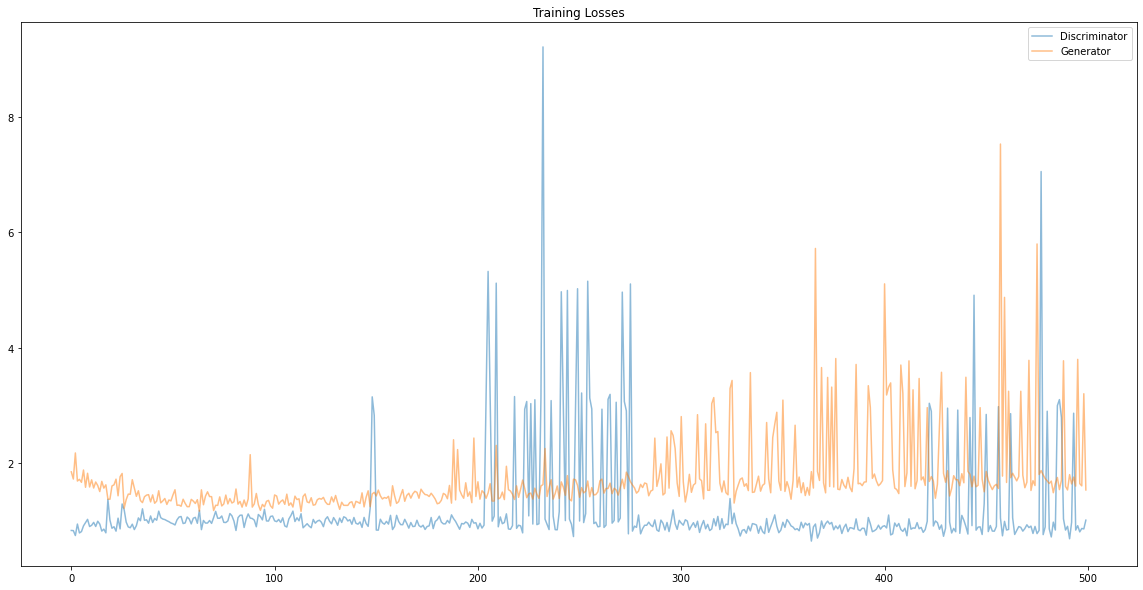

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

By looking at the graph, it can be seen that after some point (around epoch 300), the generator loss starts to rapidly raise. Meaning that the Discriminator becomes too good for the Generator. This might lead to Generator generating random noise instead of actual data. Thus, after doing some testings, I found out that the Generator at epoch number 300 showed the best results.

#### Data Regeneration

In order to test the model, I will regenerate the data 5 times to classify the regenerated data.

In [146]:
G = Generator().to(device)
G.load_state_dict(torch.load(f"./GAN/Generator_{300}"))

<All keys matched successfully>

In [147]:
# function to balance imbalanced datasets
def regen_data(generator, labels):
    generator.eval()
    
    unique_labels = np.unique(labels)
    len_dict = {}
    max_len = 0
    
    # identify the largest class
    for label in unique_labels:
        len_dict[label] = len(np.where(labels == label)[0])
        if max_len < len_dict[label]:
            max_len = len_dict[label]
            
    new_data = {}
            
    # generate new data
    for label in unique_labels:
        if max_len > len_dict[label]:
            size = max_len - len_dict[label]
            # create label tensor
            y = torch.ones((size), dtype=torch.int64).to(device) * label
            # create random noise vector
            z = np.random.uniform(-1, 1, size=(size, z_size))
            z = torch.from_numpy(z).float().to(device)
            
            new_data[label] = G(z, y).cpu().detach().numpy()
            
    return new_data

In [148]:
add_data = []
for i in range(5):
    add_data.append(regen_data(G, y_train))

#### Classification

For classification I will use Random Forest Classifier, Explainable Boosting Classifier, and simple Neural Network Classifier.

In [149]:
from sklearn.ensemble import RandomForestClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import f1_score

In [150]:
class SimpleClassifier(nn.Module):
    
  def __init__(self, i_size=39, h_dim=15, n_classes=10):
    super(SimpleClassifier, self).__init__()
    
    self.classifier = nn.Sequential(
      nn.Linear(i_size, h_dim),
      nn.ReLU(True),
      nn.Linear(h_dim, n_classes)
    )
    
    self.classifier.apply(self.__init_weights)

  def forward(self, x):
    out = self.classifier(x)
    
    return out
  
  def __init_weights(self,m):
    #Init the weights (optional)
    if type(m) == nn.Linear:
      torch.nn.init.xavier_uniform_(m.weight)
      m.bias.data.fill_(0.01)

In [151]:
def train_SimpleClassifier(model, train_loader, num_epochs = 20):
    learning_rate = 1e-4
    eps = 1e-9
    
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, eps=eps)
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    
    for epoch in range(num_epochs):
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            # forward
            output = model(X)
            loss = criterion(output, y)
            
            # backward
            loss.backward()
            optimizer.step()
        
        # log
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
        
    return model

In [152]:
gc.collect()

100

##### Classification on original dataset

In [164]:
forest_cl = RandomForestClassifier(max_depth=50, n_jobs=-1)
eb_cl = ExplainableBoostingClassifier(max_bins=2, n_jobs=-1, interactions=0, max_leaves=50) # more than 2 bins takes forever; something is not right
nn_cl = SimpleClassifier().to(device)

In [155]:
X_train_np = X_train.numpy()
y_train_np = y_train.numpy()
X_test_np = X_test.numpy()
y_test_np = y_test.numpy()

In [167]:
# Random Forest
forest_cl.fit(X_train_np, y_train_np)
y_pred = forest_cl.predict(X_test_np)
forest_error = f1_score(y_test_np, y_pred, average="weighted")

In [165]:
# Explainable Boosting
eb_cl.fit(X_train_np, y_train_np)
y_pred = eb_cl.predict(X_test_np)
eb_error = f1_score(y_test_np, y_pred, average="weighted")

/home/vallre/anaconda3/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:922: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


In [168]:
# train
train_SimpleClassifier(nn_cl, train_loader)
# test
nn_cl.eval()
outputs = nn_cl(X_test.to(device))
y_pred = torch.max(outputs.data, 1)[1].cpu().detach().numpy()
nn_error = f1_score(y_test_np, y_pred, average="weighted")

epoch [1/20], loss:0.9247
epoch [2/20], loss:0.9570
epoch [3/20], loss:0.8632
epoch [4/20], loss:0.4689
epoch [5/20], loss:0.8454
epoch [6/20], loss:0.7746
epoch [7/20], loss:0.5120
epoch [8/20], loss:0.3363
epoch [9/20], loss:0.7435
epoch [10/20], loss:0.6886
epoch [11/20], loss:0.7820
epoch [12/20], loss:0.9286
epoch [13/20], loss:0.7852
epoch [14/20], loss:0.5181
epoch [15/20], loss:0.7733
epoch [16/20], loss:0.5586
epoch [17/20], loss:0.6387
epoch [18/20], loss:0.6746
epoch [19/20], loss:0.5992
epoch [20/20], loss:0.6121


In [169]:
print("Baseline to beat:")
print("Forest weighted f1_score:", forest_error)
print("Explainable Boosting weighted f1_score:", eb_error)
print("Neural Netwirk weighted f1_score:", nn_error)

Baseline to beat:
Forest weighted f1_score: 0.7787574638917493
Explainable Boosting weighted f1_score: 0.2786813200227937
Neural Netwirk weighted f1_score: 0.7151489293910189


##### Classification on Regenerated Dataset

In [170]:
gc.collect()

88

In [172]:
forest_errors = []
eb_errors = []
nn_errors = []

# unpack each K-fold
for data_dict in tqdm(add_data):
    inputs = []
    labels = []
    
    # exctract the generated data
    for label, data in data_dict.items():
        size = len(data)
        labels.append(np.ones(size) * label)
        inputs.append(data)
        
    labels.append(y_train_np)
    inputs.append(X_train_np)
    # create new train dataset
    new_X_train_np = np.concatenate(inputs)
    new_y_train_np = np.concatenate(labels)
    
    # shuffle the data
    shuffle_idx = np.random.permutation(len(new_X_train_np))
    
    new_X_train_np = new_X_train_np[shuffle_idx]
    new_y_train_np = new_y_train_np[shuffle_idx]
    
    # create new train loader
    new_X_train = torch.tensor(new_X_train_np)
    new_y_train = torch.tensor(new_y_train_np, dtype=torch.int64)
    
    new_train_loader = DataLoader(TensorDataset(new_X_train, new_y_train), batch_size=batch, shuffle=True)
    
    # init classifiers
    forest_cl = RandomForestClassifier(max_depth=50, n_jobs=-1)
    eb_cl = ExplainableBoostingClassifier(max_bins=2, n_jobs=-1, interactions=0, max_leaves=50)
    nn_cl = SimpleClassifier().to(device)
    
    print("Working on Random Forest")
    # Random Forest
    forest_cl.fit(new_X_train_np, new_y_train_np)
    y_pred = forest_cl.predict(X_test_np)
    forest_errors.append(f1_score(y_test_np, y_pred, average="weighted"))
    
    print("Working on Explainable Boosting")
    # Explainable Boosting
    eb_cl.fit(new_X_train_np, new_y_train_np)
    y_pred = eb_cl.predict(X_test_np)
    eb_errors.append(f1_score(y_test_np, y_pred, average="weighted"))
    
    # train
    train_SimpleClassifier(nn_cl, new_train_loader)
    # test
    nn_cl.eval()
    outputs = nn_cl(X_test.to(device))
    y_pred = torch.max(outputs.data, 1)[1].cpu().detach().numpy()
    nn_errors.append(f1_score(y_test_np, y_pred, average="weighted"))
    
forest_errors = np.array(forest_errors)
eb_errors = np.array(eb_errors)
nn_errors = np.array(nn_errors)

  0%|          | 0/5 [00:00<?, ?it/s]

Working on Random Forest
Working on Explainable Boosting


/home/vallre/anaconda3/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:922: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


epoch [1/20], loss:0.9810
epoch [2/20], loss:0.7594
epoch [3/20], loss:0.7417
epoch [4/20], loss:0.4748
epoch [5/20], loss:0.5048
epoch [6/20], loss:0.6860
epoch [7/20], loss:0.6801
epoch [8/20], loss:0.4803
epoch [9/20], loss:0.4581
epoch [10/20], loss:0.5912
epoch [11/20], loss:0.5469
epoch [12/20], loss:0.6755
epoch [13/20], loss:0.3603
epoch [14/20], loss:0.5177
epoch [15/20], loss:0.6777
epoch [16/20], loss:0.3352
epoch [17/20], loss:0.3359
epoch [18/20], loss:0.3762
epoch [19/20], loss:0.5801


 20%|██        | 1/5 [09:45<39:00, 585.11s/it]

epoch [20/20], loss:0.2636
Working on Random Forest
Working on Explainable Boosting


/home/vallre/anaconda3/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:922: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


epoch [1/20], loss:0.8835
epoch [2/20], loss:0.5664
epoch [3/20], loss:0.6198
epoch [4/20], loss:0.5691
epoch [5/20], loss:0.5652
epoch [6/20], loss:0.4855
epoch [7/20], loss:0.7141
epoch [8/20], loss:0.7571
epoch [9/20], loss:0.6262
epoch [10/20], loss:0.4582
epoch [11/20], loss:0.6271
epoch [12/20], loss:0.4077
epoch [13/20], loss:0.6311
epoch [14/20], loss:0.5247
epoch [15/20], loss:0.5812
epoch [16/20], loss:5.5253
epoch [17/20], loss:0.3954
epoch [18/20], loss:0.4510
epoch [19/20], loss:0.7857


 40%|████      | 2/5 [21:06<30:42, 614.09s/it]

epoch [20/20], loss:0.6630
Working on Random Forest
Working on Explainable Boosting


/home/vallre/anaconda3/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:922: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


epoch [1/20], loss:1.0219
epoch [2/20], loss:0.8064
epoch [3/20], loss:0.6301
epoch [4/20], loss:0.5510
epoch [5/20], loss:0.5673
epoch [6/20], loss:0.9335
epoch [7/20], loss:0.6023
epoch [8/20], loss:0.5774
epoch [9/20], loss:0.7958
epoch [10/20], loss:0.5927
epoch [11/20], loss:0.5037
epoch [12/20], loss:0.3687
epoch [13/20], loss:0.3453
epoch [14/20], loss:0.5573
epoch [15/20], loss:0.4640
epoch [16/20], loss:0.5749
epoch [17/20], loss:0.3850
epoch [18/20], loss:0.3751
epoch [19/20], loss:0.4002


 60%|██████    | 3/5 [30:00<19:39, 589.84s/it]

epoch [20/20], loss:0.4508
Working on Random Forest
Working on Explainable Boosting


/home/vallre/anaconda3/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:922: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


epoch [1/20], loss:0.8473
epoch [2/20], loss:0.7933
epoch [3/20], loss:0.7107
epoch [4/20], loss:0.8288
epoch [5/20], loss:0.5925
epoch [6/20], loss:0.4513
epoch [7/20], loss:0.6106
epoch [8/20], loss:0.3952
epoch [9/20], loss:0.5666
epoch [10/20], loss:0.4694
epoch [11/20], loss:0.4596
epoch [12/20], loss:0.5524
epoch [13/20], loss:0.6425
epoch [14/20], loss:0.3263
epoch [15/20], loss:0.5361
epoch [16/20], loss:0.3706
epoch [17/20], loss:0.4602
epoch [18/20], loss:0.4559
epoch [19/20], loss:0.3946


 80%|████████  | 4/5 [38:05<09:18, 558.52s/it]

epoch [20/20], loss:0.3406
Working on Random Forest
Working on Explainable Boosting


/home/vallre/anaconda3/lib/python3.8/site-packages/interpret/glassbox/ebm/ebm.py:922: UserWarning: Multiclass is still experimental. Subject to change per release.
  warn("Multiclass is still experimental. Subject to change per release.")


epoch [1/20], loss:0.6730
epoch [2/20], loss:0.7187
epoch [3/20], loss:0.7096
epoch [4/20], loss:0.5780
epoch [5/20], loss:0.5805
epoch [6/20], loss:0.7753
epoch [7/20], loss:0.6105
epoch [8/20], loss:0.5577
epoch [9/20], loss:0.7156
epoch [10/20], loss:0.5710
epoch [11/20], loss:0.4283
epoch [12/20], loss:0.5874
epoch [13/20], loss:0.4257
epoch [14/20], loss:0.6409
epoch [15/20], loss:0.3822
epoch [16/20], loss:0.5130
epoch [17/20], loss:0.3661
epoch [18/20], loss:0.4071
epoch [19/20], loss:0.4414


100%|██████████| 5/5 [48:48<00:00, 585.67s/it]

epoch [20/20], loss:0.3732


In [173]:
print("5-fold cross-validated f1 scores:")
print("Forest weighted f1_score:", forest_errors.mean(), "with std", forest_errors.std())
print("Explainable Boosting weighted f1_score:", eb_errors.mean(), "with std", eb_errors.std())
print("Neural Netwirk weighted f1_score:", nn_errors.mean(), "with std", nn_errors.std())

5-fold cross-validated f1 scores:
Forest weighted f1_score: 0.7790133605711614 with std 0.0002985039197262466
Explainable Boosting weighted f1_score: 0.01291852067126705 with std 0.015749829317629912
Neural Netwirk weighted f1_score: 0.7021735318870735 with std 0.004443696435668471


Seems like the scores stayed the same. The `std` is much lower than the mean, thus, the generator did not produce its output by chance.

In [174]:
forest_cl = RandomForestClassifier(max_depth=100, n_jobs=-1)

In [175]:
from sklearn.metrics import classification_report

# Random Forest
forest_cl.fit(X_train_np, y_train_np)
y_pred = forest_cl.predict(X_test_np)
forest_error = f1_score(y_test_np, y_pred, average="weighted")

print(classification_report(y_test_np, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.76      0.85     37000
           1       0.02      0.10      0.03       583
           2       0.00      0.01      0.00       677
           3       0.29      0.57      0.39      6062
           4       0.33      0.71      0.46       378
           5       0.93      0.80      0.86      3496
           6       0.62      0.78      0.69     11132
           7       0.63      0.11      0.19      4089
           8       0.62      0.18      0.28        44
           9       1.00      0.97      0.98     18871

    accuracy                           0.76     82332
   macro avg       0.54      0.50      0.47     82332
weighted avg       0.84      0.76      0.78     82332



In [176]:
# Random Forest
forest_cl.fit(new_X_train_np, new_y_train_np)
y_pred = forest_cl.predict(X_test_np)
forest_error = f1_score(y_test_np, y_pred, average="weighted")

print(classification_report(y_test_np, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.76      0.85     37000
           1       0.02      0.14      0.04       583
           2       0.02      0.05      0.03       677
           3       0.29      0.56      0.38      6062
           4       0.34      0.70      0.46       378
           5       0.93      0.80      0.86      3496
           6       0.62      0.78      0.69     11132
           7       0.60      0.11      0.19      4089
           8       0.50      0.20      0.29        44
           9       1.00      0.97      0.98     18871

    accuracy                           0.76     82332
   macro avg       0.53      0.51      0.48     82332
weighted avg       0.84      0.76      0.78     82332



Seems like the generated data has better f1 scores for rare classes. However, the problem of imbalance was not fully solved.